<a href="https://colab.research.google.com/github/Murcha1990/ML_AI25/blob/main/Hometasks/Pro/AI_HW1_Regression_with_inference_pro_pt1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Домашнее задание №1 (pro). Часть 1**

В этом домашнем задании (его первой части) вам будет необходимо:
*  обучить модель регрессии для предсказания стоимости автомобилей;


> Оценка за первую часть домашки = $min(\text{ваш балл}, 7)$



**Примечание**

В каждой части оцениваются как код, **так и ответы на вопросы.** Вопросы подсвечены синим цветом.

Если нет одного и/или другого, то часть баллов за соответствующее задание снимается.

In [1]:
# %pip install -q ydata-profiling

In [2]:
# %pip install -q phik

In [3]:
# %pip install -q category_encoders

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns

from ydata_profiling import ProfileReport

import re
from IPython.display import display

from phik.report import plot_correlation_matrix
from phik import phik_matrix

from sklearn.metrics import r2_score, mean_squared_error as MSE
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.pipeline import Pipeline

from category_encoders import TargetEncoder

random.seed(42)
np.random.seed(42)

### **Задание 0**
Давайте зафиксируем важный момент.

**Задание 0 (0 баллов).**
Изучите и ответье на вопрос: для чего фиксируем сиды в домашках?

Для воспроизводимости экспериментов  
В противном случае, функции генерирующие псевдослучайные значения будут выдавать разные результаты

# **Часть 1 | EDA**


Первая часть состоит из классических шагов EDA:

- Базовый EDA и обработка признаков (1.7 балла)
- Визуализации признаков и их анализ (1.6 балл)

Всего можно набрать 3.3 основных балла и 0.25 бонусных.

В следующих частях, вы увидите бонусные задания. Бонусные задания выделены как **Дополнительное задание/Бонус**. Вы можете выполнять их, чтобы в случае ошибок в основных задачах всё равно набрать за работу максимум. Кроме того, дополнительные задания позволяют вам углубить знания.

Призываем активно использовать их!

## **Простейший EDA и обработка признаков (1.7 балла)**

In [5]:
df_train = pd.read_csv('https://raw.githubusercontent.com/Murcha1990/MLDS_ML_2022/main/Hometasks/HT1/cars_train.csv')
df_test = pd.read_csv('https://raw.githubusercontent.com/Murcha1990/MLDS_ML_2022/main/Hometasks/HT1/cars_test.csv')

print("Train data shape:", df_train.shape)
print("Test data shape: ", df_test.shape)

Train data shape: (6999, 13)
Test data shape:  (1000, 13)


In [6]:
df_train.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm,5.0
2,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5.0
3,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.1 kmpl,1298 CC,88.2 bhp,"11.5@ 4,500(kgm@ rpm)",5.0
4,Hyundai Xcent 1.2 VTVT E Plus,2017,440000,45000,Petrol,Individual,Manual,First Owner,20.14 kmpl,1197 CC,81.86 bhp,113.75nm@ 4000rpm,5.0


In [7]:
df_test.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Mahindra Xylo E4 BS IV,2010,229999,168000,Diesel,Individual,Manual,First Owner,14.0 kmpl,2498 CC,112 bhp,260 Nm at 1800-2200 rpm,7.0
1,Tata Nexon 1.5 Revotorq XE,2017,665000,25000,Diesel,Individual,Manual,First Owner,21.5 kmpl,1497 CC,108.5 bhp,260Nm@ 1500-2750rpm,5.0
2,Honda Civic 1.8 S AT,2007,175000,218463,Petrol,Individual,Automatic,First Owner,12.9 kmpl,1799 CC,130 bhp,172Nm@ 4300rpm,5.0
3,Honda City i DTEC VX,2015,635000,173000,Diesel,Individual,Manual,First Owner,25.1 kmpl,1498 CC,98.6 bhp,200Nm@ 1750rpm,5.0
4,Tata Indica Vista Aura 1.2 Safire BSIV,2011,130000,70000,Petrol,Individual,Manual,Second Owner,16.5 kmpl,1172 CC,65 bhp,96 Nm at 3000 rpm,5.0


### **Задание 1.(0.4 балла)**
Выполните операции, направленные на базовое исследование данных:

- [ ] Посмотрите, есть ли в датасете пропуски и дубликаты. Запишите/выведите названия колонок, для которых есть пропущенные значения (0.1 балла)
- [ ] Посмотрите, есть ли в данных явные дубликаты (0.05 балла)
- [ ] Постройте дашборд в одну строку, используя [ydata-profilling](https://github.com/ydataai/ydata-profiling)(0.15 балла)
- [ ] Опишите базовые выводы (какие — выберите сами), используя дашборд (0.2 балла).

In [8]:
for i in range(0, len(df_train)):
  try:
    ffil_value = float(df_train.loc[i, 'max_power'][:-4])
    df_train.loc[i, 'max_power'] = ffil_value

  except:
    if df_train.loc[i, 'max_power'] in [np.nan, 'nan']:
      continue
    elif df_train.loc[i, 'max_power'] == '0':
      ffil_value = float(df_train.loc[i, 'max_power'])
      df_train.loc[i, 'max_power'] = ffil_value
    else:
      df_train.loc[i, 'max_power'] = 0


In [9]:
missing_cols = df_train.columns[df_train.isna().any()].tolist()
print("Колонки с пропусками:", missing_cols)

Колонки с пропусками: ['mileage', 'engine', 'max_power', 'torque', 'seats']


In [10]:
num_duplicates = df_train.duplicated().sum()
print("Количество дубликатов:", num_duplicates)

Количество дубликатов: 985


In [11]:
profile = ProfileReport(df_train, explorative=True, minimal=True, title="Отчет-профайлинг")

In [12]:
# profile.to_notebook_iframe()

Саммари по датасету (на основе дашборда):
1. В некоторых колонках есть пропуски (1% ячеек)
2. В датасете есть дубли (7%)
3. Есть и текстовые, и категориальные, и числовые признаки
4. Есть признаки с высокой корреляцией

### **Задание 2 (0.2 балла)**
Проанализируйте статистики датасета.

**Ваша задача:**
- [ ] Посчитайте основные статистики по числовым столбцам для трейна и теста
- [ ] Посчитайте основные статистики по категориальным столбцам для трейна и теста
- [ ] Сравните среднее и медиану внутри `train`, внутри `test` и между собой. О чём могут говорить результаты?
- [ ] Сделайте выводы по статистикам. Отсутсвие выводов равносильно по баллам невыполнению задания.

**Подсказка:**

Используте ``.describe()`` с нужным(и) аргументом(-ами).

In [13]:
df_train.dtypes

name              object
year               int64
selling_price      int64
km_driven          int64
fuel              object
seller_type       object
transmission      object
owner             object
mileage           object
engine            object
max_power         object
torque            object
seats            float64
dtype: object

In [14]:
numeric_cols = df_train.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = df_train.select_dtypes(include=['object']).columns

print("Числовые признаки:", list(numeric_cols))
print("Категориальные признаки:", list(categorical_cols))

Числовые признаки: ['year', 'selling_price', 'km_driven', 'seats']
Категориальные признаки: ['name', 'fuel', 'seller_type', 'transmission', 'owner', 'mileage', 'engine', 'max_power', 'torque']


In [15]:
train_numeric_stats = df_train[numeric_cols].describe().T
test_numeric_stats = df_test[numeric_cols].describe().T

In [16]:
# Числовые признаки train

train_numeric_stats

,count,mean,std,min,25%,50%,75%,max
year,6999.0,2013.818403,4.053095,1983.0,2011.0,2015.0,2017.0,2020.0
selling_price,6999.0,639515.197171,808941.911915,29999.0,254999.0,450000.0,675000.0,10000000.0
km_driven,6999.0,69584.615517,57724.001817,1.0,35000.0,60000.0,97000.0,2360457.0
seats,6797.0,5.419008,0.965767,2.0,5.0,5.0,5.0,14.0


In [17]:
# Числовые признаки test


test_numeric_stats

,count,mean,std,min,25%,50%,75%,max
year,1000.0,2013.681000,4.012149,1995.0,2011.0,2014.0,2017.0,2020.0
selling_price,1000.0,617901.042000,758553.860710,31000.0,250000.0,434999.0,670000.0,6000000.0
km_driven,1000.0,71393.341000,48486.218662,1303.0,37000.0,61500.0,100000.0,375000.0
seats,981.0,5.410805,0.919985,4.0,5.0,5.0,5.0,9.0


In [18]:
train_categorical_stats = df_train[categorical_cols].describe().T
test_categorical_stats = df_test[categorical_cols].describe().T

In [19]:
# Категориальные признаки train


train_categorical_stats

,count,unique,top,freq
name,6999,1924,Maruti Swift Dzire VDI,116
fuel,6999,4,Diesel,3793
seller_type,6999,3,Individual,5826
transmission,6999,2,Manual,6095
owner,6999,5,First Owner,4587
mileage,6797,386,18.9 kmpl,197
engine,6797,120,1248 CC,885
max_power,6803.0,313.0,74.0,330.0
torque,6796,419,190Nm@ 2000rpm,468


In [20]:
# Категориальные признаки test

test_categorical_stats

,count,unique,top,freq
name,1000,621,Maruti Alto 800 LXI,15
fuel,1000,4,Diesel,534
seller_type,1000,3,Individual,837
transmission,1000,2,Manual,877
owner,1000,5,First Owner,623
mileage,981,237,18.6 kmpl,23
engine,981,88,1248 CC,116
max_power,981,182,74 bhp,43
torque,981,226,200Nm@ 1750rpm,57


In [21]:
train_mean = df_train[numeric_cols].mean()
train_median = df_train[numeric_cols].median()

test_mean = df_test[numeric_cols].mean()
test_median = df_test[numeric_cols].median()

mean_median_comparison = pd.DataFrame({

    "train_mean": train_mean,
    "train_median": train_median,
    "test_mean": test_mean,
    "test_median": test_median,

    "train_mean - test_mean": train_mean - test_mean,
    "train_median - test_median": train_median - test_median,

    "train_mean_%_test_mean": ((train_mean - test_mean) / test_mean) * 100,
    "train_median_%_test_median": ((train_median - test_median) / test_median) * 100
})

mean_median_comparison

,train_mean,train_median,test_mean,test_median,train_mean - test_mean,train_median - test_median,train_mean_%_test_mean,train_median_%_test_median
year,2013.818403,2015.0,2013.681000,2014.0,0.137403,1.0,0.006823,0.049652
selling_price,639515.197171,450000.0,617901.042000,434999.0,21614.155171,15001.0,3.497996,3.448514
km_driven,69584.615517,60000.0,71393.341000,61500.0,-1808.725483,-1500.0,-2.533465,-2.439024
seats,5.419008,5.0,5.410805,5.0,0.008203,0.0,0.151606,0.000000


Выводы:
1. Присутствует некоторый сдвиг в данных:
   1. Средняя/медианная цена выше на трейне, 
   2. Средний/медианный пробег выше на тесте (очевидно, эти два факторы скоррелированы)
   3. В тесте отсутсвуют 2-местные машины и 14-местные машины
   4. В тесте отсутствуют новые машины (с пробегом 1.0)
2. Остальные данные выглядят согласованно

### **Задание 3 (0.2 балла)**

- [ ] Посмотрите, есть ли в трейне объекты с одинаковым признаковым описанием (целевую переменную следует исключить). Если есть, то сколько? (0.01 балла)
- [ ] Отобразите такие объекты (0.01 балла)
- [ ] Удалите повторяющиеся строки. Если при одинаковом признаковом описании цены на автомобили отличаются, то оставьте первую строку по этому автомобилю (0.01 балла)
- [ ]  Обновите индексы строк таким образом, чтобы они шли от 0 без пропусков (0.01 балла)
- [ ] Подумайте, могут ли в данных быть другие скрытые дубли? Предложите, как их можно отлавливать. (0.16 балла)

P.S тут данные без подвоха, но выводы нам нужны.

In [22]:
features = list(df_train.columns.drop("selling_price"))

In [23]:
duplicate_mask = df_train.duplicated(subset=features, keep=False)
num_duplicates = duplicate_mask.sum()

df_train[duplicate_mask].sort_values(by=features).head(20)

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
1703,Audi Q3 2.0 TDI Quattro Premium Plus,2017,2825000,22000,Diesel,Dealer,Automatic,First Owner,15.73 kmpl,1968 CC,174.33,380Nm@ 1750-2500rpm,5.0
6307,Audi Q3 2.0 TDI Quattro Premium Plus,2017,2825000,22000,Diesel,Dealer,Automatic,First Owner,15.73 kmpl,1968 CC,174.33,380Nm@ 1750-2500rpm,5.0
1836,Audi Q5 3.0 TDI Quattro,2014,1850000,76131,Diesel,Individual,Automatic,First Owner,13.22 kmpl,2967 CC,241.4,580Nm@ 1400-3250rpm,5.0
6704,Audi Q5 3.0 TDI Quattro,2014,1850000,76131,Diesel,Individual,Automatic,First Owner,13.22 kmpl,2967 CC,241.4,580Nm@ 1400-3250rpm,5.0
117,Audi Q5 35TDI Premium Plus,2018,3975000,31800,Diesel,Dealer,Automatic,First Owner,17.01 kmpl,1968 CC,188.0,400nm@ 1750-3000rpm,5.0
1337,Audi Q5 35TDI Premium Plus,2018,3975000,31800,Diesel,Dealer,Automatic,First Owner,17.01 kmpl,1968 CC,188.0,400nm@ 1750-3000rpm,5.0
1595,Audi Q5 35TDI Premium Plus,2018,3975000,31800,Diesel,Dealer,Automatic,First Owner,17.01 kmpl,1968 CC,188.0,400nm@ 1750-3000rpm,5.0
2787,Audi Q5 35TDI Premium Plus,2018,3975000,31800,Diesel,Dealer,Automatic,First Owner,17.01 kmpl,1968 CC,188.0,400nm@ 1750-3000rpm,5.0
4485,Audi Q5 35TDI Premium Plus,2018,3975000,31800,Diesel,Dealer,Automatic,First Owner,17.01 kmpl,1968 CC,188.0,400nm@ 1750-3000rpm,5.0
6640,Audi Q5 35TDI Premium Plus,2018,3975000,31800,Diesel,Dealer,Automatic,First Owner,17.01 kmpl,1968 CC,188.0,400nm@ 1750-3000rpm,5.0


In [24]:
df_train = df_train.drop_duplicates(subset=features, keep='first')

In [25]:
df_train = df_train.reset_index(drop=True)

In [26]:
df_train.shape


(5840, 13)

In [27]:
assert df_train.shape == (5840, 13)

Предположу, что скрыте дубликаты могут еще появляться из-за категориальных колонок -- например, из-за одинаковых по сути но разных по написанию категорий (e.g. max_poser = 74.0 и max_power = 74 bhp), из-за регистров и т.п.  
Возможно, могут быть дубли и и-за числовых колонок (разны округления, разные системы измерения), но это менее вероятно, как мне кажется  
Базовый способ  это обойти -- более умно подойти к сравнению кат. переменных (нормализация строк, приближенное сравнения (через токенизацию, например) и т.п.)

### **Задание 4 (0.3 балла)**

Вы могли заметить, что с признаками ``mileage, engine, max_power и torque`` всё не очень хорошо. Они распознаются как строки (можно убедиться в этом, вызвав `data.dtypes`). Однако эти переменные не являются категориальными — они — числа. Соответственно, нужно привести их к числовому виду.

**Задача :**
* [ ] Уберите единицы измерения для признаков ``mileage, engine, max_power``.
* [ ] Приведите тип данных к ``float``.
* [ ] Предобработайте признак `torque` — разделите его на два: собственно `torque` и `max_torque_rpm`. Учтите единицы измерения


**Важно**
- Все действия нужно производить над обоими датасетами — `train` и `test`.

In [28]:
df_train[["mileage", "engine", "max_power", 'torque']].head(n=10)

,mileage,engine,max_power,torque
0,23.4 kmpl,1248 CC,74.0,190Nm@ 2000rpm
1,21.14 kmpl,1498 CC,103.52,250Nm@ 1500-2500rpm
2,23.0 kmpl,1396 CC,90.0,22.4 kgm at 1750-2750rpm
3,16.1 kmpl,1298 CC,88.2,"11.5@ 4,500(kgm@ rpm)"
4,20.14 kmpl,1197 CC,81.86,113.75nm@ 4000rpm
5,17.3 km/kg,1061 CC,57.5,"7.8@ 4,500(kgm@ rpm)"
6,16.1 kmpl,796 CC,37.0,59Nm@ 2500rpm
7,23.59 kmpl,1364 CC,67.1,170Nm@ 1800-2400rpm
8,20.0 kmpl,1399 CC,68.1,160Nm@ 2000rpm
9,19.01 kmpl,1461 CC,108.45,248Nm@ 2250rpm


In [29]:
df_train[['torque']].head(n=10)

,torque
0,190Nm@ 2000rpm
1,250Nm@ 1500-2500rpm
2,22.4 kgm at 1750-2750rpm
3,"11.5@ 4,500(kgm@ rpm)"
4,113.75nm@ 4000rpm
5,"7.8@ 4,500(kgm@ rpm)"
6,59Nm@ 2500rpm
7,170Nm@ 1800-2400rpm
8,160Nm@ 2000rpm
9,248Nm@ 2250rpm


Объявление: в двух функциях ниже воспользовался LLM-кой для составления регулярок

In [30]:
def parse_rpm(x):
    if "-" in x:
        a, b = x.split("-")
        a = float(a.replace(",", "").replace(" ", ""))
        b = float(b.replace(",", "").replace(" ", ""))
        return (a + b) / 2
    else:
        return float(x.replace(",", "").replace(" ", "")) if x != "" else np.nan


def parse_torque_column(df):
    df = df.copy()
    torque_raw = df["torque"].astype(str)

    df["torque_value"] = torque_raw.str.extract(r"([0-9]*\.?[0-9]+)").astype(float)

    df["torque_unit"] = torque_raw.str.extract(r"(nm|NM|Nm|kgm|KGm|kgm?)")

    df["torque"] = np.where(
        df["torque_unit"].str.lower().str.contains("kg", na=False),
        df["torque_value"] * 9.8,
        df["torque_value"]
    )

    rpm_extract = torque_raw.str.extract(
        r"([0-9][0-9,.-]*[0-9])(?=[^0-9]*rpm)",
    )

    df["rpm_raw"] = rpm_extract[0].fillna("")
    df["max_torque_rpm"] = df["rpm_raw"].apply(parse_rpm)

    df = df.drop(columns=["torque_value", "torque_unit", "rpm_raw"])
    return df


In [31]:
def fix_dataset(df):
    df = df.copy()

    df["mileage"] = (
        df["mileage"]
        .astype(str)
        .str.extract(r"([0-9]*\.?[0-9]+)")
        .astype(float)
    )

    df["engine"] = (
        df["engine"]
        .astype(str)
        .str.extract(r"([0-9]*\.?[0-9]+)")
        .astype(float)
    )

    df["max_power"] = (
        df["max_power"]
        .astype(str)
        .str.extract(r"([0-9]*\.?[0-9]+)")
        .astype(float)
    )

    df_torque_max_torque = parse_torque_column(df)

    return df_torque_max_torque

In [32]:
df_train_fixed = fix_dataset(df_train)

display(df_train.head())
display(df_train_fixed.head())

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74.0,190Nm@ 2000rpm,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52,250Nm@ 1500-2500rpm,5.0
2,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90.0,22.4 kgm at 1750-2750rpm,5.0
3,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.1 kmpl,1298 CC,88.2,"11.5@ 4,500(kgm@ rpm)",5.0
4,Hyundai Xcent 1.2 VTVT E Plus,2017,440000,45000,Petrol,Individual,Manual,First Owner,20.14 kmpl,1197 CC,81.86,113.75nm@ 4000rpm,5.0


,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats,max_torque_rpm
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.40,1248.0,74.00,190.00,5.0,2000.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14,1498.0,103.52,250.00,5.0,2000.0
2,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.00,1396.0,90.00,219.52,5.0,2250.0
3,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.10,1298.0,88.20,112.70,5.0,4500.0
4,Hyundai Xcent 1.2 VTVT E Plus,2017,440000,45000,Petrol,Individual,Manual,First Owner,20.14,1197.0,81.86,113.75,5.0,4000.0


In [33]:
df_test_fixed = fix_dataset(df_test)

display(df_test.head())
display(df_test_fixed.head())

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Mahindra Xylo E4 BS IV,2010,229999,168000,Diesel,Individual,Manual,First Owner,14.0 kmpl,2498 CC,112 bhp,260 Nm at 1800-2200 rpm,7.0
1,Tata Nexon 1.5 Revotorq XE,2017,665000,25000,Diesel,Individual,Manual,First Owner,21.5 kmpl,1497 CC,108.5 bhp,260Nm@ 1500-2750rpm,5.0
2,Honda Civic 1.8 S AT,2007,175000,218463,Petrol,Individual,Automatic,First Owner,12.9 kmpl,1799 CC,130 bhp,172Nm@ 4300rpm,5.0
3,Honda City i DTEC VX,2015,635000,173000,Diesel,Individual,Manual,First Owner,25.1 kmpl,1498 CC,98.6 bhp,200Nm@ 1750rpm,5.0
4,Tata Indica Vista Aura 1.2 Safire BSIV,2011,130000,70000,Petrol,Individual,Manual,Second Owner,16.5 kmpl,1172 CC,65 bhp,96 Nm at 3000 rpm,5.0


,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats,max_torque_rpm
0,Mahindra Xylo E4 BS IV,2010,229999,168000,Diesel,Individual,Manual,First Owner,14.0,2498.0,112.0,260.0,7.0,2000.0
1,Tata Nexon 1.5 Revotorq XE,2017,665000,25000,Diesel,Individual,Manual,First Owner,21.5,1497.0,108.5,260.0,5.0,2125.0
2,Honda Civic 1.8 S AT,2007,175000,218463,Petrol,Individual,Automatic,First Owner,12.9,1799.0,130.0,172.0,5.0,4300.0
3,Honda City i DTEC VX,2015,635000,173000,Diesel,Individual,Manual,First Owner,25.1,1498.0,98.6,200.0,5.0,1750.0
4,Tata Indica Vista Aura 1.2 Safire BSIV,2011,130000,70000,Petrol,Individual,Manual,Second Owner,16.5,1172.0,65.0,96.0,5.0,3000.0


### **Задание 5 (0.3 балла)**

На первом шаге мы обнаружили пропуски. Давайте избавимся от них.

**Задание:**
- [ ] Заполните пропуски в столбцах медианами. Убедитесь, что после заполнения пропусков не осталось.
- [ ] Почему стоит применять именно медиану. Могли ли мы применить среднее? Обоснуйте свое рассуждение.
- [ ] Как правильно считать медиану для заполнения? Выберите верное утверждение:
 - По тестовым свою, по тренировочным — свою
 - По тренировочным данным для `train` и `test`






In [34]:
numeric_cols = df_train_fixed.select_dtypes(include=['float64', 'int64']).columns # список изменился
numeric_cols

Index(['year', 'selling_price', 'km_driven', 'mileage', 'engine', 'max_power',
       'torque', 'seats', 'max_torque_rpm'],
      dtype='object')

In [35]:
train_medians = df_train_fixed[numeric_cols].median()

In [36]:
df_train_fixed[numeric_cols] = df_train_fixed[numeric_cols].fillna(train_medians)
df_test_fixed[numeric_cols] = df_test_fixed[numeric_cols].fillna(train_medians)

In [37]:
print(df_train_fixed[numeric_cols].isna().sum().sum())
print(df_test_fixed[numeric_cols].isna().sum().sum())

0
0


* Чаще всего (как в нашем случае) используется именно медиана, потому что среднее больше подвержено выбросам, смещениям и так далее, т.е. медиана более "стабильна"
* Среднее использовать тоже можно, но при условии, что распрееделение симметрично, выбросов нет, данные примерно нормальные
* В целом, исходя из дашборда, под наш случай это тоже подходит, но выбираем заполнение медианой
* Использовать раздельнуые для train/test значения медиан нельзя, иначе получим по сути лик данных. Поэтому сначала считаем медианы на train, test тоже им заполняем

### **Задание 6 (0.2 балла)**

Теперь, когда не осталось пропусков, давайте преобразуем столбцы к более подходящим типам. А именно столбцы ``engnine`` и ``seats`` к приведем к `int`.

- [ ] Осуществите приведение столбцов к необходимому типу.
- [ ] Ответье на вопрос — почему (хоть мы этого и не делаем) ``seats``, возможно рассмотреть как категориальную переменную?

In [38]:
df_train_fixed[["engine", "seats"]] = df_train_fixed[["engine", "seats"]].astype('int')
df_test_fixed[["engine", "seats"]] = df_test_fixed[["engine", "seats"]].astype('int')

seats можно расмотреть как категориальную, потому что у нее маленький и только целочисленный диапазон значений, который еще и соответствует определенным категориям машин (спортивные, седаны, автобусы, ...)

### **Задание 7 (0.1 балла)**

Снова вызовите метод describe и проанализируйте статистики.

**Ответье на вопрос:**
- [ ] Есть ли основания предполагать, что заполнение пропусков свдинуло наши распределения? Могло ли это вообще возникнуть?

In [39]:
df_train.describe()

,year,selling_price,km_driven,seats
count,5840.000000,5.840000e+03,5.840000e+03,5654.00000
mean,2013.428425,5.229601e+05,7.395224e+04,5.44075
std,4.095622,5.354320e+05,6.007114e+04,0.99527
min,1983.000000,2.999900e+04,1.000000e+00,2.00000
25%,2011.000000,2.500000e+05,3.900000e+04,5.00000
50%,2014.000000,4.050000e+05,7.000000e+04,5.00000
75%,2017.000000,6.400000e+05,1.000000e+05,5.00000
max,2020.000000,1.000000e+07,2.360457e+06,14.00000


In [40]:
df_train_fixed.describe()

,year,selling_price,km_driven,mileage,engine,max_power,torque,seats,max_torque_rpm
count,5840.000000,5.840000e+03,5.840000e+03,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000
mean,2013.428425,5.229601e+05,7.395224e+04,19.430841,1429.448973,87.892354,174.976693,5.426712,2844.476113
std,4.095622,5.354320e+05,6.007114e+04,3.985973,485.662834,31.661223,107.290298,0.982344,977.591600
min,1983.000000,2.999900e+04,1.000000e+00,0.000000,624.000000,0.000000,14.900000,2.000000,500.000000
25%,2011.000000,2.500000e+05,3.900000e+04,16.950000,1197.000000,68.000000,111.720000,5.000000,2000.000000
50%,2014.000000,4.050000e+05,7.000000e+04,19.370000,1248.000000,81.860000,160.000000,5.000000,2400.000000
75%,2017.000000,6.400000e+05,1.000000e+05,22.300000,1498.000000,99.000000,200.000000,5.000000,3750.000000
max,2020.000000,1.000000e+07,2.360457e+06,42.000000,3604.000000,400.000000,1862.000000,14.000000,21800.000000


Я не вижу оснований для выводов о стат. значимом сдвиге распределения

## **Визуализации и корреляция (1.6 балла + 0.25)**

Визуализация данных — важный шаг в работе. Визуализировать данные необходимо, например, чтобы:

- Оценить распределения признаков самих по себе (это может натоклнуть вас на мысли о модели, которую можно использовать)
- Сравнить распределения на `train` и `test` — чтобы проверить, насколько информация, на которой вы будете обучаться согласуется с той, на которой модель должна работать
- Оценить есть ли явная связь признаков с целевой переменной

**Важно:**

Если распределения на `train` и `test` не совпадают, это не значит, что нужно перемешивать данные! Более корректно актуализировать задачу и уточнить, а не устарели ли данные `train`. Также полезным может быть собрать новую тестовую выборку, смешав те, что имеются сейчас.

**Если вы будете подгонять распределения, то можете встретиться с переобучением!**

### **Задание 8 (0.5 балла)**

Шаг 1.
- [ ] Воспользуйтесь `pairplot` из библиотеки `seabron`, чтобы визуализировать попарные распределения числовых признаков для `train`
- [ ] По полученному графику ответьте на вопросы:
 - Можно ли предположить на основе распределений связь признаков с целевой переменной?
 - Можно ли предположить на основе распределений выдвинуть гипотезу о корреляциях признаков?

Шаг 2.

- [ ] Постройте pairplot по тестовым данным
- [ ] Ответьте на вопрос "Похожими ли оказались совокупности при разделении на трейн и тест?"

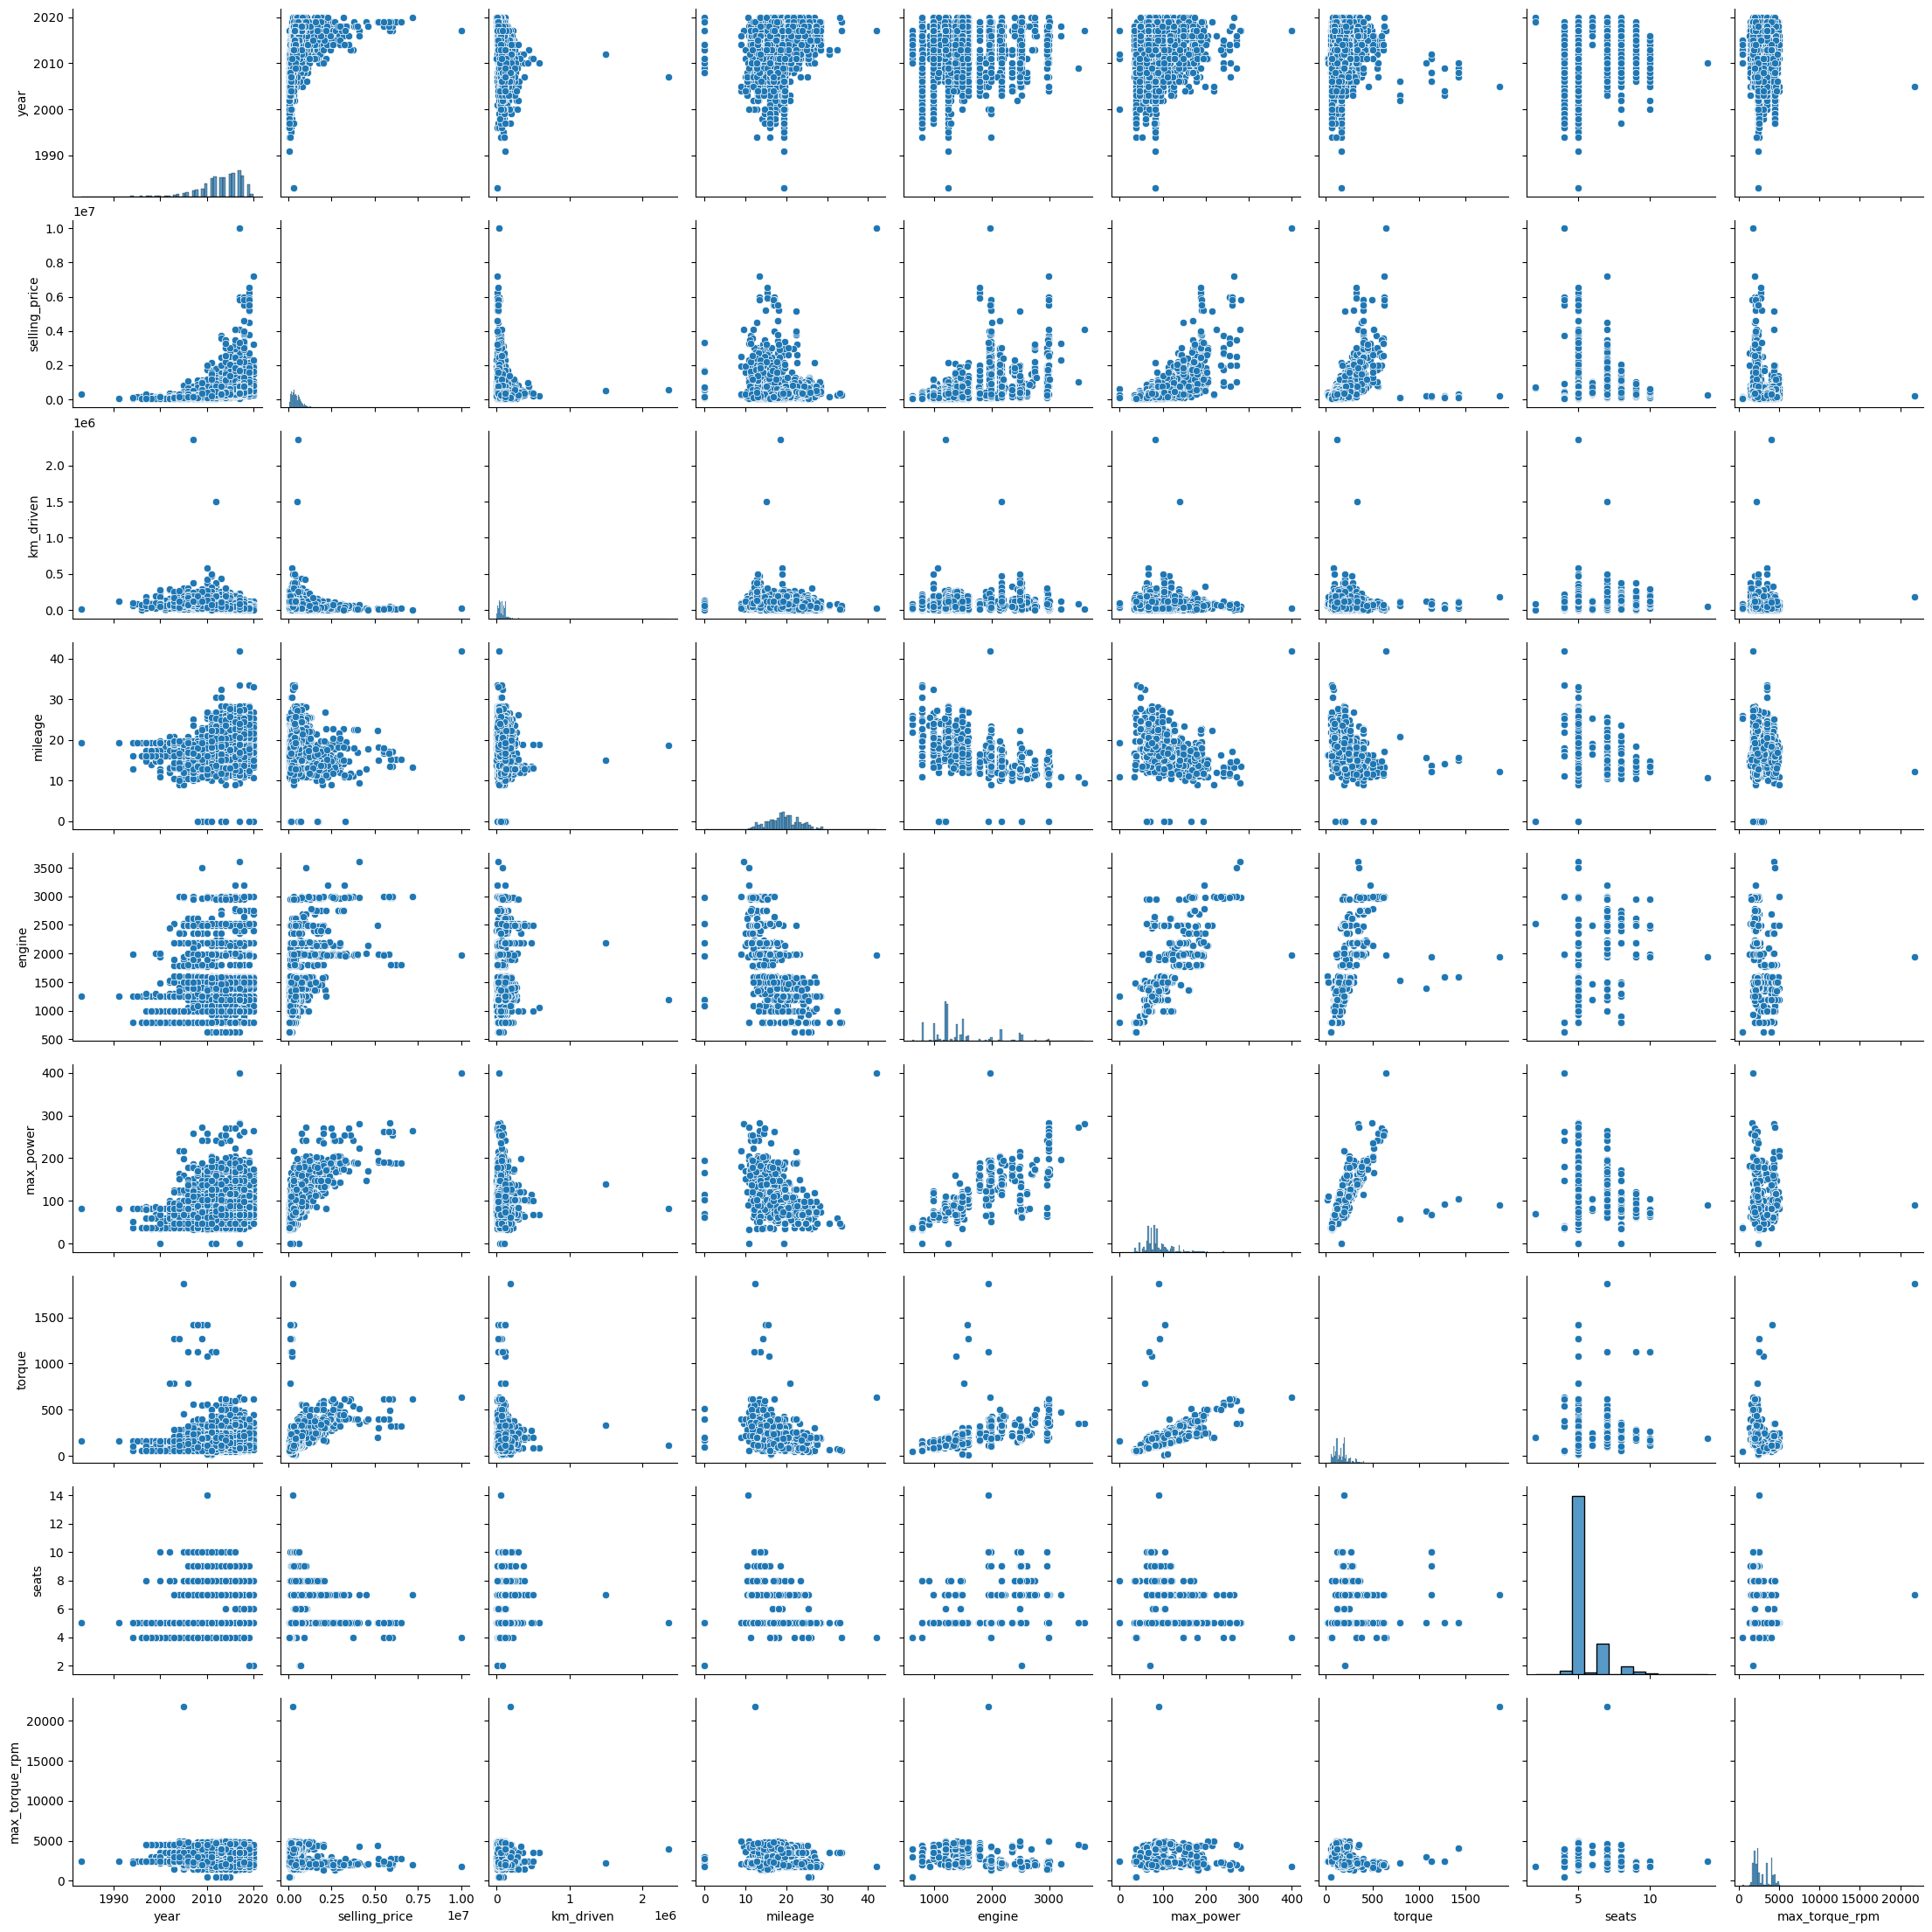

In [41]:
sns.pairplot(df_train_fixed[numeric_cols], diag_kind="hist")
plt.show()

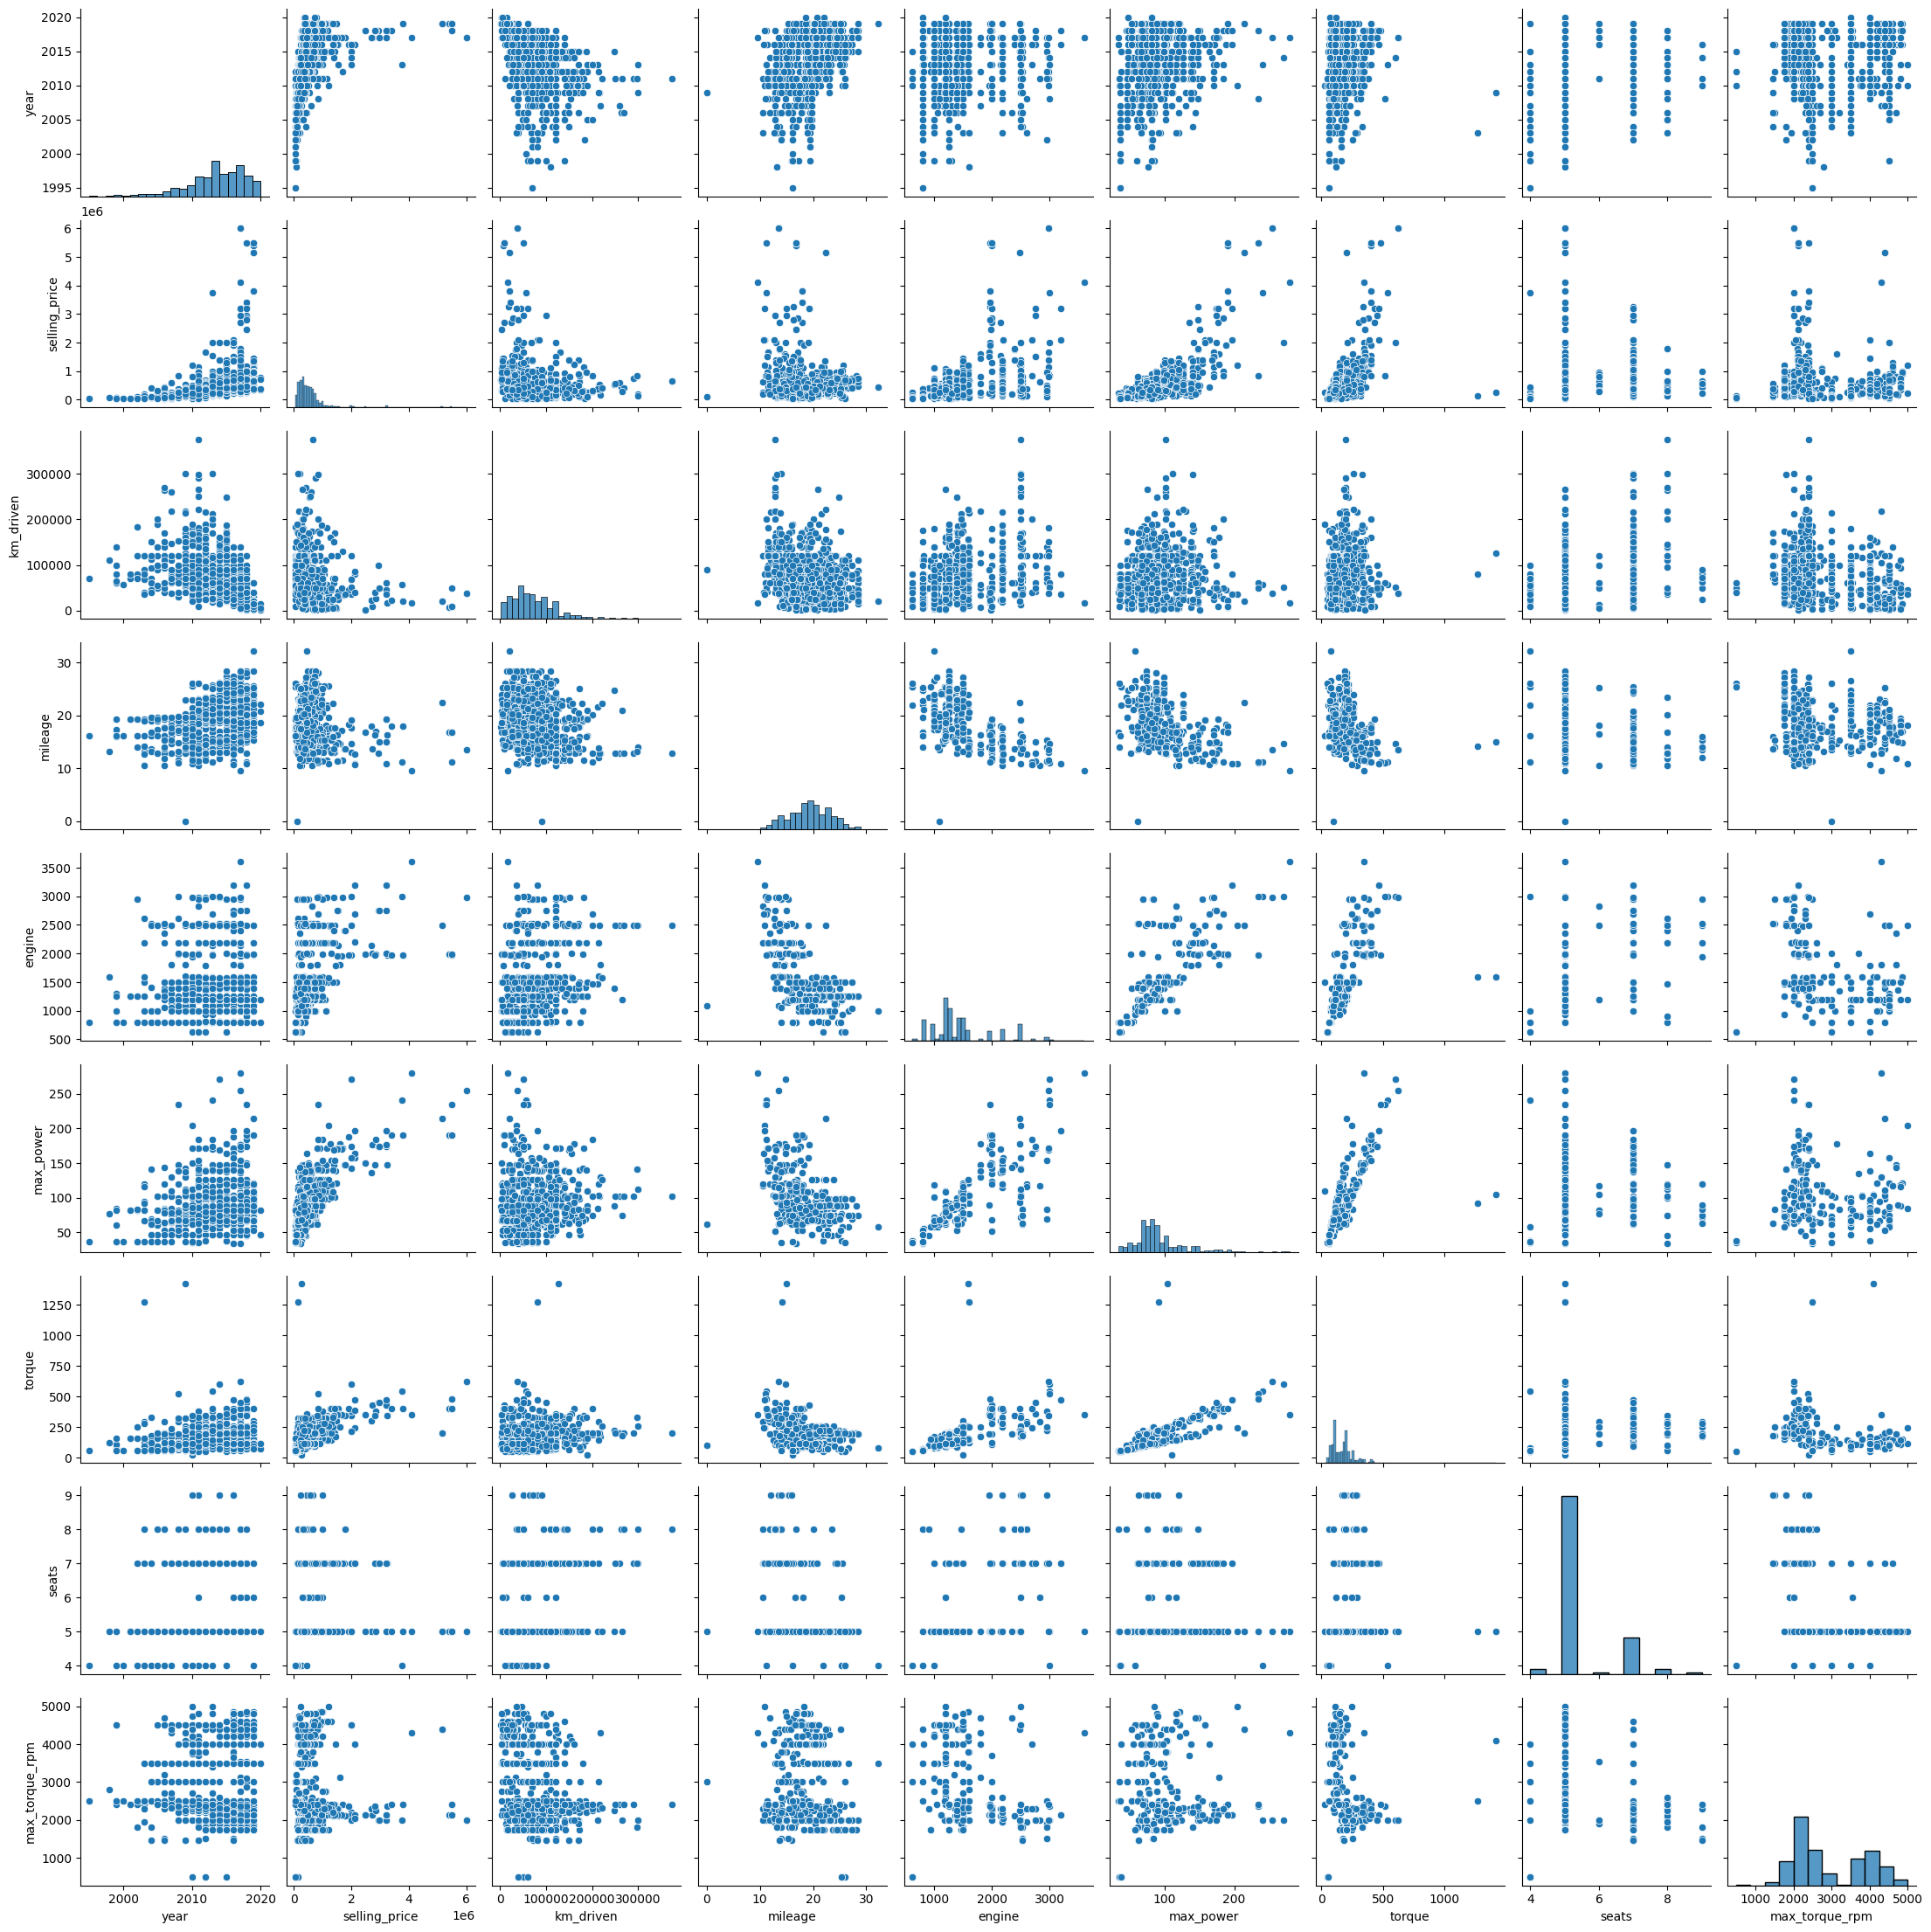

In [42]:
sns.pairplot(df_test_fixed[numeric_cols], diag_kind="hist")
plt.show()

* Из графиков train:
  * Связь с целевой переменной:
    * engine -> selling_price (растут вместе)
    * max_power -> selling_price (растут вместе)
    * torque -> selling_price (растут вместе)
    * km_driven <- selling price (растут обратно)
    * year -> selling_price (растут вместе)
    * seats <-> selling_price (зависимость хаотичная)
  * Корреляция между признаками:
    * engine <-> max_power (сильная положительная)
    * engine <-> torque (сильная положительная)
    * max_power <-> torque (сильная положительная)
    * У остальных признаков корреляция не так очевидна
* Из графиков test:
  * У большинства признаков распределения выглядят такими же по формам и диапазонам
  * Однако, возможно присутствует временной сдвиг -- в test попали более новые данные
  * Но, для умеющий экстраполировать линейной модели это не должно быть критично -- не будем смешивать выборки 

### **Задание 9 (0.5 балла)**

И так, вы выдвинули гипотезы о наличии связи. Теперь давайте оценим эту связь в числах.

**Задание:**
- [ ] Получите значения коэффициента корреляции Пирсона для тренировочного набора данных при помощи `pd.corr()`
- [ ] По полученным корреляциям постройте тепловую карту (`heatmap` из бибилотеки seaborn)

In [43]:
corr_matrix = df_train_fixed[numeric_cols].corr(method="pearson")
corr_matrix

,year,selling_price,km_driven,mileage,engine,max_power,torque,seats,max_torque_rpm
year,1.000000,0.427279,-0.368966,0.341334,0.002819,0.158207,0.055737,0.041178,0.032423
selling_price,0.427279,1.000000,-0.164828,-0.104769,0.447672,0.692725,0.467420,0.149953,-0.172447
km_driven,-0.368966,-0.164828,1.000000,-0.182086,0.229766,0.024379,0.111372,0.192328,-0.226878
mileage,0.341334,-0.104769,-0.182086,1.000000,-0.572893,-0.372197,-0.234402,-0.451059,-0.100298
engine,0.002819,0.447672,0.229766,-0.572893,1.000000,0.681247,0.598654,0.652172,-0.372949
max_power,0.158207,0.692725,0.024379,-0.372197,0.681247,1.000000,0.656363,0.242791,-0.144744
torque,0.055737,0.467420,0.111372,-0.234402,0.598654,0.656363,1.000000,0.317306,-0.358057
seats,0.041178,0.149953,0.192328,-0.451059,0.652172,0.242791,0.317306,1.000000,-0.288047
max_torque_rpm,0.032423,-0.172447,-0.226878,-0.100298,-0.372949,-0.144744,-0.358057,-0.288047,1.000000


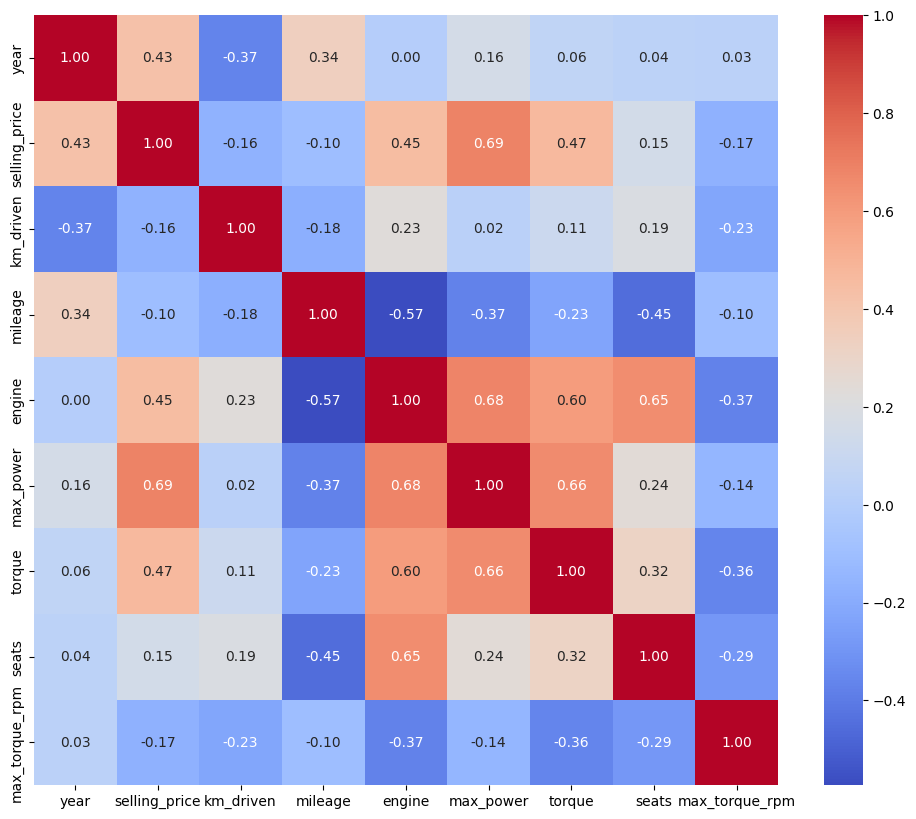

In [44]:
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.show()

- [ ] Ответьте на вопросы:
 - Какие 2 признака наименее скоррелированы между собой?
 - Между какими наблюдается довольно сильная положительная линейная зависимость?
 - Правильно ли, опираясь на данные, утверждать, что чем меньше год, тем, скорее всего, больше километров проехала машина к дате продажи?
 - Изучите типы корреляций в `pd.corr()`. Какую вы использовали по умолчанию?

`Your answer here`
* year и engine вообще не скоррелированы
* у engine и max_power корреляция 0.68
* у year и km_driven корреляция -0.37, так что предложенная взаимосвязь имеет место быть
* использовалась корреляция Пирсона

### **Задание 10 (0.6 балла)**

По умолчанию `pd.corr` возвращает корреляцию Пирсона, говорящую о линейной взаимосвязи. Но зависимости существуют не только линейные! В этой задаче, попробуйте измерить другие способы вычисления корреляций.

- [ ] Реализуйте корреляцию Спирмена/Кендала (на выбор) без использования библиотек (можно пользоваться только `numpy`). Сравните результаты вычисления с библиотечной реализацией
- [ ] Сделайте выводы


Постройте матрицу корреляции [phik](https://pypi.org/project/phik/)
- [ ] Проинтерпретируйте результаты


In [45]:
# Ранговая корреляция Спирмена
def spearman_manual(x, y):
    
    rx = np.argsort(np.argsort(x))
    ry = np.argsort(np.argsort(y))

    rx = rx - rx.mean()
    ry = ry - ry.mean()

    return np.sum(rx * ry) / np.sqrt(np.sum(rx**2) * np.sum(ry**2))


In [46]:
corr_matrix_spearman = df_train_fixed[numeric_cols].corr(method="spearman")
corr_matrix_spearman

,year,selling_price,km_driven,mileage,engine,max_power,torque,seats,max_torque_rpm
year,1.000000,0.707123,-0.569659,0.346132,-0.038056,0.166267,0.112332,0.048291,0.001649
selling_price,0.707123,1.000000,-0.295665,0.026186,0.463577,0.612600,0.585316,0.317605,-0.251594
km_driven,-0.569659,-0.295665,1.000000,-0.198466,0.304504,0.040655,0.235267,0.195317,-0.303867
mileage,0.346132,0.026186,-0.198466,1.000000,-0.429871,-0.308239,-0.149904,-0.435458,-0.162101
engine,-0.038056,0.463577,0.304504,-0.429871,1.000000,0.713435,0.834172,0.527716,-0.463041
max_power,0.166267,0.612600,0.040655,-0.308239,0.713435,1.000000,0.771014,0.304095,-0.147133
torque,0.112332,0.585316,0.235267,-0.149904,0.834172,0.771014,1.000000,0.434221,-0.645609
seats,0.048291,0.317605,0.195317,-0.435458,0.527716,0.304095,0.434221,1.000000,-0.304394
max_torque_rpm,0.001649,-0.251594,-0.303867,-0.162101,-0.463041,-0.147133,-0.645609,-0.304394,1.000000


In [47]:
corr_matrix_spearman_manual = df_train_fixed[numeric_cols].corr(method=spearman_manual)
corr_matrix_spearman_manual

,year,selling_price,km_driven,mileage,engine,max_power,torque,seats,max_torque_rpm
year,1.000000,0.705060,-0.566218,0.342960,-0.034677,0.167250,0.115082,0.050485,-0.000471
selling_price,0.705060,1.000000,-0.295699,0.026164,0.461866,0.612589,0.585543,0.220670,-0.251364
km_driven,-0.566218,-0.295699,1.000000,-0.197687,0.303411,0.040088,0.233164,0.105454,-0.302763
mileage,0.342960,0.026164,-0.197687,1.000000,-0.428987,-0.308118,-0.149600,-0.307221,-0.159698
engine,-0.034677,0.461866,0.303411,-0.428987,1.000000,0.711976,0.831921,0.361660,-0.460928
max_power,0.167250,0.612589,0.040088,-0.308118,0.711976,1.000000,0.770144,0.199996,-0.147743
torque,0.115082,0.585543,0.233164,-0.149600,0.831921,0.770144,1.000000,0.285798,-0.643484
seats,0.050485,0.220670,0.105454,-0.307221,0.361660,0.199996,0.285798,1.000000,-0.208058
max_torque_rpm,-0.000471,-0.251364,-0.302763,-0.159698,-0.460928,-0.147743,-0.643484,-0.208058,1.000000


In [48]:
np.allclose(corr_matrix_spearman, corr_matrix_spearman_manual, rtol=0.25, atol=0.1)

True

На первый взгляд результаты похожи, тем не менее, совпадения удалось достигнуть только при rtol=0.25

<Figure size 1200x1000 with 0 Axes>

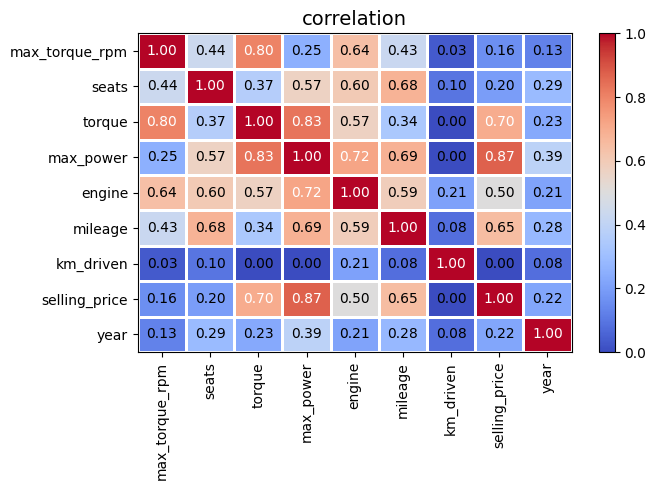

In [49]:
phik_corr = df_train_fixed[numeric_cols].phik_matrix(interval_cols=df_train_fixed.columns.tolist())

plt.figure(figsize=(12, 10))
plot_correlation_matrix(phik_corr.values, 
                        x_labels=phik_corr.columns, 
                        y_labels=phik_corr.index, 
                        vmin=0, vmax=1, 
                        color_map="coolwarm")
plt.show()

Абсолютные значения корреляций увеличились -- значит, действительно присутствуют не только линейные монотонные зависимости между переменными (их и находит phik)

### **Дополнительные визуализации (бонус 0.25 балла)**

Если вам кажется, что мы не попросили вас нарисовать какие-то очень важные зависимости, нарисуйте их и поясните.
Один график: 0.125 балла, при условии, что он обоснован.

In [50]:
# your code here

# **Часть 2 (1.7 балла) | Модель только на вещественных признаках**

В этой части вам предстоит обучить модель только на вещественных признаках. Почему только на них?

Чем больше признаковое пространство — чем сложнее модель. А чем модель проще — тем лучше для скорости работы и интерпретации признаков.

За задания этой части вы можете набрать 1.7 основных и 0.15 бонусных балла;

### **Задание 11 (0.05 балла)**

Разбейте данные на тренировочный и тестовый наборы. Перед разбиением создайте копию датафрейма, который будет хранить только вещественные признаки и используйте его (то есть категориальные столбцы (все, кроме seats) необходимо удалить).

В переменные y_train и y_test запишите значения целевых переменных.

In [51]:
X_train = df_train_fixed[numeric_cols].copy().drop(['selling_price'], axis=1)
y_train = df_train_fixed[numeric_cols].copy()['selling_price']

In [52]:
assert X_train.shape == (5840, 8) # исправил assert

In [53]:
X_test = df_test_fixed[numeric_cols].copy().drop(['selling_price'], axis=1)
y_test = df_test_fixed[numeric_cols].copy()['selling_price']

In [54]:
assert X_test.shape == (1000, 8)

### **Задание 12. (0.2 балла)**

Построим нашу первую модель!
- [ ] Обучите классическую линейную регрессию с дефолтными параметрами. Посчтитайте $R^2$ и $MSE$ для трейна и для теста.
- [ ] Сделайте выводы по значениям метрик качества.

**Примечание:**

Здесь и далее $R^2$ и $MSE$ для трейна и для теста выводите везде, где требуется обучать модели, даже если в явном виде этого не просят. Иначе непонятно, как понять, насколько успешны наши эксперименты.

In [55]:
lr = LinearRegression()
lr.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [56]:
y_pred_train_lr = lr.predict(X_train)
y_pred_test_lr = lr.predict(X_test)

In [57]:
r2_train = r2_score(y_train, y_pred_train_lr)
r2_test = r2_score(y_test, y_pred_test_lr)

mse_train = MSE(y_train, y_pred_train_lr)
mse_test = MSE(y_test, y_pred_test_lr)

In [58]:
display(r2_train, r2_test, mse_train, mse_test)

0.6011152240715787

0.5991888374249723

114335669368.38062

230397701666.76892

In [59]:
coef = lr.coef_
features = X_train.columns

for f, c in sorted(zip(features, coef), key=lambda x: abs(x[1]), reverse=True):
    print(f, c)

year 40456.86597535486
seats -32234.718905926515
max_power 10216.279326378502
mileage -2741.7956929012557
torque 94.17989551154595
max_torque_rpm -64.60329205006221
engine 31.115041611321853
km_driven -0.829515261774263


### **Задание 13 (0.15 балла)**

- [ ] Реализуйте $R^2$ руками. Приведите формулу $R^2$ и объясните каждую компоненту метрики

In [60]:
def r2_manual(y_true, y_pred):
    rss = np.sum((y_true - y_pred)**2)
    tss = np.sum((y_true - np.mean(y_true))**2)
    return 1 - rss / tss

`Your answer here`
* RSS -- сумма квадратов остатков; По сути -- насколько плохо модель сделала предсказания
* TSS -- общая сумма квадратов; По сути -- насколько сложное надо делать предсказание
* Тогда R^2 --  доля объясненной моделью дисперсии; сколько по итогу получилось предсказать из общей суммы

### **Бонус (0.15 балла)**

- [ ] Реализуйте [$\text{adjusted}-R^2$](https://en.wikipedia.org/wiki/Coefficient_of_determination).
- [ ] Объясните, когда применяется $\text{adjusted}-R^2$?

In [61]:
def adjusted_r2(y_true, y_pred, n, p): # используем в связке с R^2

    rss = np.sum((y_true - y_pred)**2)
    tss = np.sum((y_true - np.mean(y_true))**2)
    r2 = 1 - rss / tss

    return 1 - (1 - r2) * (n - 1) / (n - p - 1)

`Your answer here`
* adjusted R^2 используется для штрафования модели за лишние признаки (т.к. обычный R^2 всегда растет)

### **Задание 14 (0.05 балла)**

Всегда есть место совершенству. Поэтому давайте попробуем улучшить модель. При помощи стандартизации признаков.

- [ ] Стандартизируйте значения в тренировочных и тестовых данных. Стандартизатор **обучайте только на `train`**.

In [62]:
scaler = StandardScaler()
scaler.fit(X_train)

,copy,True
,with_mean,True
,with_std,True


In [63]:
X_train_scaled = scaler.transform(X_train)
X_test_scaled  = scaler.transform(X_test)

In [64]:
lr_scaled = LinearRegression()
lr_scaled.fit(X_train_scaled, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [65]:
y_pred_train_scaled = lr_scaled.predict(X_train_scaled)
y_pred_test_scaled = lr_scaled.predict(X_test_scaled)

In [66]:
r2_train = r2_score(y_train, y_pred_train_scaled)
r2_test = r2_score(y_test, y_pred_test_scaled)

mse_train = MSE(y_train, y_pred_train_scaled)
mse_test = MSE(y_test, y_pred_test_scaled)

In [67]:
r2_train, r2_test, mse_train, mse_test

(0.6011152240715785,
 0.5991888374249731,
 114335669368.38065,
 230397701666.76843)

### **Задание 15 (0.1 балла)**

Хотя стандартизация не помогла сильно прибавить в качестве она открыла возможность интерпретировать важность признаков в модели. Правило интерпретации такое:

Чем больше коэффициент $\beta_i$ по модулю, тем важнее признак.

**Ответьте на вопрос:**

- [ ] Какой признак оказался наиболее информативным в предсказании цены?

In [68]:
coef = lr_scaled.coef_
features = X_train.columns

for f, c in sorted(zip(features, coef), key=lambda x: abs(x[1]), reverse=True):
    print(f, c)

max_power 323432.20429573976
year 165681.84119195602
max_torque_rpm -63150.22826670311
km_driven -49825.65807905899
seats -31662.869891105223
engine 15110.125433104857
mileage -10927.788328666182
torque 10103.723873514366


Получили, что  наиболее информативен признак max_power -- у него наибольший коэффициент  
Это согласуется с его наибольшей корреляцией с целевой переменной

### **Задание 16 (0.25 балла)**

Попробуем улучшить нашу модель с помощью применения регуляризации. Для этого воспльзуемся `Lasso` регрессией.  Кроме того, попробуйте использовать её теоретическое свойство отбора признаков, за счет зануления незначимых коэффициентов.

**Задание:**

- [ ] Обучите Lasso регрессию на тренировочном наборе данных с нормализованными признаками. Оцените её качество
- [ ] Проверьте, занулила ли L1-регуляризация с параметрами по умолчанию какие-нибудь веса? Предположите почему.

In [69]:
lasso = Lasso()
lasso.fit(X_train_scaled, y_train)

,alpha,1.0
,fit_intercept,True
,precompute,False
,copy_X,True
,max_iter,1000
,tol,0.0001
,warm_start,False
,positive,False
,random_state,None
,selection,'cyclic'


In [70]:
y_pred_train_lasso = lasso.predict(X_train_scaled)
y_pred_test_lasso  = lasso.predict(X_test_scaled)

In [71]:
r2_train_lasso = r2_score(y_train, y_pred_train_lasso)
r2_test_lasso  = r2_score(y_test,  y_pred_test_lasso)

mse_train_lasso = MSE(y_train, y_pred_train_lasso)
mse_test_lasso  = MSE(y_test,  y_pred_test_lasso)

In [72]:
r2_train_lasso, r2_test_lasso, mse_train_lasso, mse_test_lasso

(0.6011152240263523, 0.5991875773740054, 114335669381.3442, 230398425980.04626)

In [73]:
coef = lasso.coef_
features = X_train.columns

for f, c in sorted(zip(features, coef), key=lambda x: abs(x[1]), reverse=True):
    print(f, c)

max_power 323433.77203609503
year 165679.73142758332
max_torque_rpm -63148.21982565545
km_driven -49824.69633898035
seats -31658.87955777397
engine 15108.173092895398
mileage -10924.64716016384
torque 10103.049638363991


Lasso-регрессия не занулила никаких весов.  
Предположу, что это происходит из-за двух причин:
* Признаков небольшое количество
* Все признаки информативны
* Дефолтный параметр alpha в Lasso=1.0 может быть слишком маленьким, его может быть недостаточно для обнуления

### **Задание 17. Финальный рывок (0.4 балла)**

До этого мы с вами использовали `train` для обучения и `test` для прогнозирования. Но у нас есть ещё одна задача — подобрать оптимальные параметры модели. Для этого используем кросс-валидацию, описанную на семинарах.

Кроме того, выжмем максимум из модификаций регрессии. Построим `ElasticNet`. И сделаем всё по порядку.

**Ваша задача 1:**

- [ ] Перебором по сетке (c 10-ю фолдами) подберите оптимальные параметры для Lasso-регрессии. Вам пригодится класс [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).
- [ ] Ответьте на вопросы:
 - Сколько грид-сёрчу пришлось обучать моделей?
 - Что значит каждый параметр `param_grid`, который вы заполняли для `GridSearch`? Опишите каждый
 - Какой коэффициент регуляризации у лучшей из перебранных моделей? Занулились ли какие-нибудь из весов при такой регуляризации?

In [74]:
param_grid = {
    "alpha": np.logspace(-4, 6, 30)
}

In [75]:
lasso_grid = Lasso(max_iter=10000)

grid = GridSearchCV(
    estimator=lasso_grid,
    param_grid=param_grid,
    cv=10,
    scoring="r2"
)

In [76]:
grid.fit(X_train_scaled, y_train)

,estimator,Lasso(max_iter=10000)
,param_grid,{'alpha': array([1.0000...00000000e+06])}
,scoring,'r2'
,n_jobs,None
,refit,True
,cv,10
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,alpha,np.float64(18873.918221350996)


In [77]:
best_alpha = grid.best_params_["alpha"]
best_alpha

np.float64(18873.918221350996)

In [78]:
best_lasso = grid.best_estimator_

In [79]:
y_pred_train_lasso_grid = best_lasso.predict(X_train_scaled)
y_pred_test_lasso_grid  = best_lasso.predict(X_test_scaled)

In [80]:
r2_train_lasso_grid = r2_score(y_train, y_pred_train_lasso_grid)
r2_test_lasso_grid  = r2_score(y_test,  y_pred_test_lasso_grid)

mse_train_lasso_grid = MSE(y_train, y_pred_train_lasso_grid)
mse_test_lasso_grid  = MSE(y_test,  y_pred_test_lasso_grid)

In [81]:
r2_train_lasso_grid, r2_test_lasso_grid, mse_train_lasso_grid, mse_test_lasso_grid

(0.5949881474991099, 0.57604542663651, 116091924416.10458, 243701195062.84784)

In [82]:
best_coeffs = best_lasso.coef_

for f, c in sorted(zip(features, best_coeffs), key=lambda x: abs(x[1]), reverse=True):
    print(f, c)

max_power 323285.5472136882
year 148411.1735067592
max_torque_rpm -38322.5267881956
km_driven -31265.973905425708
torque 672.698103050002
mileage 0.0
engine 0.0
seats -0.0


* Перебирали сетку из 30 значений альфа, 10 фолдов -> GridSearch обучил  300 моделей
* Перебирали коэффициент регуляризации альфа -- по сути, насколько сильно будем штрафовать веса
* Лучший коэффициент регуляризации -- 18874, занулились: mileage, engine, seats
* Предполагаю, что веса занулились из-за высокой корреляции (engine с max_power), слабой корреляцией с целевой переменной (mileage), просто слабости (seats)

**Ваша задача 2:**

- [ ] Перебором по сетке (c 10-ю фолдами) подберите оптимальные параметры для [ElasticNet](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html) регрессии.
- [ ] Ответьте на вопрос:
 - Сколько грид-сёрчу пришлось обучать моделей?
 - Какие гиперпараметры соответствуют лучшей (по выбранной метрике качества) из перебранных моделей?

In [83]:
param_grid_en = {
    "alpha": np.logspace(-4, 4, 20),
    "l1_ratio": np.linspace(0.01, 1.0, 10)
}

In [84]:
en = ElasticNet(max_iter=10000)

grid_en = GridSearchCV(
    estimator=en,
    param_grid=param_grid_en,
    cv=10,
    scoring="r2"
)

In [85]:
grid_en.fit(X_train_scaled, y_train)

,estimator,ElasticNet(max_iter=10000)
,param_grid,"{'alpha': array([1.0000...00000000e+04]), 'l1_ratio': array([0.01, ..., 0.89, 1. ])}"
,scoring,'r2'
,n_jobs,None
,refit,True
,cv,10
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,alpha,np.float64(0....7214690901212)


In [86]:
best_alpha = grid_en.best_params_["alpha"]
best_l1_ratio = grid_en.best_params_["l1_ratio"]

best_alpha, best_l1_ratio

(np.float64(0.23357214690901212), np.float64(0.56))

In [87]:
best_en = grid_en.best_estimator_

In [88]:
y_pred_train_en_grid = best_en.predict(X_train_scaled)
y_pred_test_en_grid  = best_en.predict(X_test_scaled)

In [89]:
r2_train_en_grid = r2_score(y_train, y_pred_train_en_grid)
r2_test_en_grid  = r2_score(y_test,  y_pred_test_en_grid)

mse_train_en_grid = MSE(y_train, y_pred_train_en_grid)
mse_test_en_grid  = MSE(y_test,  y_pred_test_en_grid)

In [90]:
r2_train_en_grid, r2_test_en_grid, mse_train_en_grid, mse_test_en_grid

(0.595589185311096, 0.576195069284166, 115919643936.38664, 243615176195.8339)

In [91]:
best_coeffs = best_en.coef_

for f, c in sorted(zip(features, best_coeffs), key=lambda x: abs(x[1]), reverse=True):
    print(f, c)

max_power 265765.7885699949
year 153653.08731356464
km_driven -51972.517928046815
engine 47701.0496536691
max_torque_rpm -45831.30925015762
torque 34499.78429268535
seats -33794.7661143256
mileage -3183.8707397346925


* Перебирались 20 значений альфа, 10 значений l1_ratio, 10 фолдов -> 2000 моделей
* Лучшие гиперпараметры: 
  * alpha = 0.233 -- штраф маленький, по сути все признаки что-то объясняют
  * l1_ratio = 0.56 -- регуляризация не хочет удалять признаки полностью, l1 лишь частично влияет

### **Задание 18 (0.35 балла)**

И так, вы обучили все варианты регуляризаций, доступные в sklearn, но не все, что мы обсудили на занятии! И следующее задание о забытой - $L0$ регуляризации.


**Ваша задача:**>
- [ ] Реализуйте модель с $L0$-регуляризаицей.
- [ ] Обучите модель на данных и проанализируйте результат, экспериментируя с коэффициенитом регуляризации
- [ ] Проанализируйте результаты обучения

**Важно:**

Вопреки тому, что L0 не реализована в стандартных пакетах, концепция данной регуляризации не является мертвой. Она может встречаться в [статьях](https://arxiv.org/abs/1712.01312) и экспериментах.



# **Часть 3 (0.5 балла) | Добавляем категориальные фичи**

Попробуем для улучшения модели дать ей больше признаков. Добавим категориальные фичи.

За эту часть можно набрать 0.5 основных балла.



### **Задание 19 (0.1 балла)**

Проанализируйте столбец `name`. Очевидно, что эта переменная является категориальной, однако категорий в ней много.

- [ ] Предобработайте столбец `name`, чтобы избежать его удаления

In [92]:
df_train_fixed["name"] = df_train_fixed["name"].str.split().str[0]
# df_train_fixed["model"] = df_train_fixed["name"].str.split().str[1:].str.join(" ")

df_test_fixed["name"] = df_test_fixed["name"].str.split().str[0]
# df_test_fixed["model"] = df_test_fixed["name"].str.split().str[1:].str.join(" ")


display(df_train_fixed.head(), df_test_fixed.head())

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats,max_torque_rpm
0,Maruti,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.40,1248,74.00,190.00,5,2000.0
1,Skoda,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14,1498,103.52,250.00,5,2000.0
2,Hyundai,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.00,1396,90.00,219.52,5,2250.0
3,Maruti,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.10,1298,88.20,112.70,5,4500.0
4,Hyundai,2017,440000,45000,Petrol,Individual,Manual,First Owner,20.14,1197,81.86,113.75,5,4000.0


,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats,max_torque_rpm
0,Mahindra,2010,229999,168000,Diesel,Individual,Manual,First Owner,14.0,2498,112.0,260.0,7,2000.0
1,Tata,2017,665000,25000,Diesel,Individual,Manual,First Owner,21.5,1497,108.5,260.0,5,2125.0
2,Honda,2007,175000,218463,Petrol,Individual,Automatic,First Owner,12.9,1799,130.0,172.0,5,4300.0
3,Honda,2015,635000,173000,Diesel,Individual,Manual,First Owner,25.1,1498,98.6,200.0,5,1750.0
4,Tata,2011,130000,70000,Petrol,Individual,Manual,Second Owner,16.5,1172,65.0,96.0,5,3000.0


In [93]:
X_train_cat = df_train_fixed.copy().drop(['selling_price'], axis=1)
X_train_cat['seats'] = X_train_cat['seats'].astype('object')

In [94]:
X_test_cat = df_test_fixed.copy().drop(['selling_price'], axis=1)
X_test_cat['seats'] = X_test_cat['seats'].astype('object')

In [95]:
assert X_train_cat.shape == (5840, 13) # исправил assert

In [96]:
X_train_cat.describe(include='object')

,name,fuel,seller_type,transmission,owner,seats
count,5840,5840,5840,5840,5840,5840
unique,30,4,3,2,5,9
top,Maruti,Diesel,Individual,Manual,First Owner,5
freq,1804,3177,5223,5336,3603,4618


пропуски в seats рассмотрим как категорию

### **Задание 20 (0.1 балла)**

- [ ] Закодируйте категориалльные фичи и ``seats`` методом OneHot-кодирования.

In [97]:
cat_cols = ["name", "fuel", "seller_type", "transmission", "owner", "seats"]
num_cols = X_train.select_dtypes(include=["int64", "float64"]).columns.tolist()

In [98]:
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), cat_cols),
        ("num", StandardScaler(), num_cols)
    ],
    remainder="drop"
)

In [99]:
preprocessor.fit(X_train_cat)

,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,categories,'auto'
,drop,'first'
,sparse_output,True


In [100]:
col_names = preprocessor.get_feature_names_out(X_train_cat.columns)

In [101]:
X_train_ohe = pd.DataFrame(
    preprocessor.transform(X_train_cat).toarray(), 
    columns=col_names,
    index=X_train_cat.index
)

X_test_ohe = pd.DataFrame(
    preprocessor.transform(X_test_cat).toarray(), 
    columns=col_names,
    index=X_test_cat.index
)

/Users/alexansemyachkin/miniconda3/envs/sneakers/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [102]:
display(X_train_ohe.head(), X_test_ohe.head())

,cat__name_Audi,cat__name_BMW,cat__name_Chevrolet,cat__name_Daewoo,cat__name_Datsun,cat__name_Fiat,cat__name_Force,cat__name_Ford,cat__name_Honda,cat__name_Hyundai,...,cat__seats_10,cat__seats_14,num__year,num__km_driven,num__mileage,num__engine,num__max_power,num__torque,num__seats,num__max_torque_rpm
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.139570,1.191152,0.995867,-0.373643,-0.438819,0.140037,-0.434419,-0.863907
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.139570,0.766619,0.428830,0.141162,0.493632,0.699315,-0.434419,-0.863907
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,-0.837167,0.883158,0.895506,-0.068879,0.066574,0.415202,-0.434419,-0.608155
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-1.569719,0.766619,-0.835712,-0.270682,0.009718,-0.580500,-0.434419,1.693617
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.872122,-0.482007,0.177929,-0.478663,-0.190544,-0.570713,-0.434419,1.182112


,cat__name_Audi,cat__name_BMW,cat__name_Chevrolet,cat__name_Daewoo,cat__name_Datsun,cat__name_Fiat,cat__name_Force,cat__name_Ford,cat__name_Honda,cat__name_Hyundai,...,cat__seats_10,cat__seats_14,num__year,num__km_driven,num__mileage,num__engine,num__max_power,num__torque,num__seats,num__max_torque_rpm
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-0.837167,1.565740,-1.362605,2.200379,0.761490,0.792528,1.601702,-0.863907
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.872122,-0.814974,0.519155,0.139102,0.650935,0.792528,-0.434419,-0.736031
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,-1.569719,2.405866,-1.638596,0.760986,1.330058,-0.027747,-0.434419,1.489015
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.383754,1.648982,1.422399,0.141162,0.338223,0.233250,-0.434419,-1.119660
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-0.592983,-0.065798,-0.735352,-0.530144,-0.723103,-0.736166,-0.434419,0.159102


### **Задание 21 (0.2 балла)**

OHE — базовый алгоритм преобразования категориальных признаков, но и с ним нужно быть аккуратными.

**Ответьте на вопросы:**


* Как корректно работать с OHE преобразованием?
* Почему мы удаляем один столбец?
* Пусть из $n$ признаков мы получили $n-1$ столбец, из которых $k < n -1$ оказались не важными по весам модели. Корректно ли их удалить?

`Your answer here`
* Корректно обучать OHE только на train, применять на test с опцией handle_unknown="ignore" для корректной обработки новых категорий
* Удаляем один столбец (drop_first=True) чтобы одна не категория не зависила линейно от остальных (все кроме нее 0 -> она 1), иначе получим мультиколлинеарность
* Думаю, что удалять корректно в рамках feature selection -- можно переформулировать категории в 2 -- отобранная категория / НЕ отобранная категория

### **Задание 22 (0.1 балла)**
Повторим то, что делали на прошлом шаге для моделей на вещественных признаках, однако теперь с моделью `Ridge`.


**Ваша задача:**
- [ ] Переберите параметр регуляризации `alpha` для гребневой (ridge) регрессии с помощью класса `GridSearchCV` В качестве параметров при объявлении GridSearchCV кроме модели укажите метрику качества $R^2$. Кроссвалидируйтесь по 10-ти фолдам.
- [ ] Ответье на вопрос: Удалось ли улучшить качество прогнозов?

In [103]:
param_grid = {
    "alpha": np.logspace(-4, 4, 20)
}

In [104]:
ridge = Ridge()

grid_ridge = GridSearchCV(
    estimator=ridge,
    param_grid=param_grid,
    cv=10,
    scoring="r2",
    n_jobs=-1
)

In [105]:
grid_ridge.fit(X_train_ohe, y_train) # варниги -- ожидаемо после OHE

,estimator,Ridge()
,param_grid,{'alpha': array([1.0000...00000000e+04])}
,scoring,'r2'
,n_jobs,-1
,refit,True
,cv,10
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,alpha,np.float64(1.623776739188721)


In [106]:
best_alpha = grid_ridge.best_params_["alpha"]
best_alpha

np.float64(1.623776739188721)

In [107]:
best_ridge = grid_ridge.best_estimator_

In [108]:
y_pred_train_ridge_grid = best_ridge.predict(X_train_ohe)
y_pred_test_ridge_grid  = best_ridge.predict(X_test_ohe)

In [109]:
r2_train_ridge_grid = r2_score(y_train, y_pred_train_ridge_grid)
r2_test_ridge_grid  = r2_score(y_test,  y_pred_test_ridge_grid)

mse_train_ridge_grid = MSE(y_train, y_pred_train_ridge_grid)
mse_test_ridge_grid  = MSE(y_test,  y_pred_test_ridge_grid)

r2_train_ridge_grid, r2_test_ridge_grid, mse_train_ridge_grid, mse_test_ridge_grid

(0.7688794934163703, 0.7777498733352521, 66247997967.5646, 127755719301.15833)

Видим значительное улучшение метрик -- ожидаемо, что модель и кат. параметры машины сильно влияют на цену 

# **Часть 4 - бонусная (1 балл) | Feature Engineering**

В этой части домашнего задания вам предлагается проявить свою креативность для улучшения прогноза модели. Любые другие модели, кроме различных форм линейной (или полиномиальной) регресси, использовать запрещается. А значит, придется работать с признаками

**Что можно попробовать сделать?** (каждый пункт по 0.4 балла, но не больше 1-х балла в сумме)

1.   *Сгенерировать новые признаки на основе уже существующих:*
    * посчитать произведения // частные признаков (кажется, что посчитать число "лошадей" на литр объема может быть полезно);
    * имеет смысл обратить внимание на визуализации в части с EDA (к примеру, зависимость цены от года выглядит квадратичной, а не линейной; значит, квадрат года нам, скорее всего, принесет больше пользы)

2.   *Добыть новые признаки:*
    * имеем название автомобиля, которое никак не используем (можно спарсить инфу о классе автомобиля или каких-то специфических опциях)
    * можно добавить пороговые признаки вроде "владелец третий или больше" и объединить признаки в некоторые осмысленные правила, например "первый или второй владелец и продавец официальный дилер" (подбирать пороги удобно по диаграммам рассеяния)

3.   *Поработать с уже имеющимися:*
    * далеко не факт, что заполнить пропуск медианой было лучшей идеей (как минимум, можно добавить dummy-столбец для модели, сигнализирующий, что раньше на месте медианы был пропуск -- там где он был, конечно); попробуйте другие способы филлинга;
    * мы не анализировали, есть ли в данных выбросы => никак выбросы не обрабатывали; наиболее простым и, тем не менее, довольно полезным вариантом нахождения выбросов могут послужить boxplot'ы для каждого столбца; что делать с выбросами думайте сами :) -- вариантов довольно много
    * мы толком не смотрели на таргет сам по себе; в нем тоже могут быть неожиданности -- стоит хотя бы проверить
    * можно заметить, что некоторые признаки распределены совсем не нормально; возможно их стоит отлогарифмировать

И так далее...

Feel Free to Try!

In [110]:
df_train_fixed["year2"] = df_train_fixed["year"] ** 2
df_test_fixed["year2"] = df_test_fixed["year"] ** 2

In [111]:
df_train_fixed["log_km"] = np.log1p(df_train_fixed["km_driven"])
df_test_fixed["log_km"] = np.log1p(df_test_fixed["km_driven"])

In [112]:
df_train_fixed["power_year"] = df_train_fixed["max_power"] * df_train_fixed["year"]
df_test_fixed["power_year"] = df_test_fixed["max_power"] * df_test_fixed["year"]

In [113]:
df_train_fixed["hp_per_liter"] = df_train_fixed["max_power"] / df_train_fixed["engine"]
df_test_fixed["hp_per_liter"] = df_test_fixed["max_power"] / df_test_fixed["engine"]

In [114]:
df_train_fixed["owner_3plus"] = (df_train_fixed["owner"].isin(["Third Owner", "Fourth & Above Owner"])).astype(int)
df_test_fixed["owner_3plus"] = (df_test_fixed["owner"].isin(["Third Owner", "Fourth & Above Owner"])).astype(int)

In [115]:
X_train = df_train_fixed.drop(['selling_price'], axis=1)
X_test = df_test_fixed.drop(['selling_price'], axis=1)

In [116]:
display(X_train, X_test)

,name,year,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats,max_torque_rpm,year2,log_km,power_year,hp_per_liter,owner_3plus
0,Maruti,2014,145500,Diesel,Individual,Manual,First Owner,23.40,1248,74.00,190.00,5,2000.0,4056196,11.887938,149036.00,0.059295,0
1,Skoda,2014,120000,Diesel,Individual,Manual,Second Owner,21.14,1498,103.52,250.00,5,2000.0,4056196,11.695255,208489.28,0.069105,0
2,Hyundai,2010,127000,Diesel,Individual,Manual,First Owner,23.00,1396,90.00,219.52,5,2250.0,4040100,11.751950,180900.00,0.064470,0
3,Maruti,2007,120000,Petrol,Individual,Manual,First Owner,16.10,1298,88.20,112.70,5,4500.0,4028049,11.695255,177017.40,0.067951,0
4,Hyundai,2017,45000,Petrol,Individual,Manual,First Owner,20.14,1197,81.86,113.75,5,4000.0,4068289,10.714440,165111.62,0.068388,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5835,Hyundai,2008,191000,Petrol,Individual,Manual,First Owner,17.92,1086,62.10,96.10,5,3000.0,4032064,12.160034,124696.80,0.057182,0
5836,Maruti,2013,50000,Petrol,Individual,Manual,Second Owner,18.90,998,67.10,90.00,5,3500.0,4052169,10.819798,135072.30,0.067234,0
5837,Hyundai,2013,110000,Petrol,Individual,Manual,First Owner,18.50,1197,82.85,113.70,5,4000.0,4052169,11.608245,166777.05,0.069215,0
5838,Hyundai,2007,119000,Diesel,Individual,Manual,Fourth & Above Owner,16.80,1493,110.00,235.20,5,2325.0,4028049,11.686887,220770.00,0.073677,1


,name,year,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats,max_torque_rpm,year2,log_km,power_year,hp_per_liter,owner_3plus
0,Mahindra,2010,168000,Diesel,Individual,Manual,First Owner,14.00,2498,112.00,260.00,7,2000.0,4040100,12.031725,225120.00,0.044836,0
1,Tata,2017,25000,Diesel,Individual,Manual,First Owner,21.50,1497,108.50,260.00,5,2125.0,4068289,10.126671,218844.50,0.072478,0
2,Honda,2007,218463,Petrol,Individual,Automatic,First Owner,12.90,1799,130.00,172.00,5,4300.0,4028049,12.294377,260910.00,0.072262,0
3,Honda,2015,173000,Diesel,Individual,Manual,First Owner,25.10,1498,98.60,200.00,5,1750.0,4060225,12.061053,198679.00,0.065821,0
4,Tata,2011,70000,Petrol,Individual,Manual,Second Owner,16.50,1172,65.00,96.00,5,3000.0,4044121,11.156265,130715.00,0.055461,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,Hyundai,2008,100000,Petrol,Individual,Manual,Second Owner,19.81,1086,68.05,99.04,5,4500.0,4032064,11.512935,136644.40,0.062661,0
996,Hyundai,2017,50000,Petrol,Individual,Manual,Second Owner,18.60,1197,81.83,114.70,5,4000.0,4068289,10.819798,165051.11,0.068363,0
997,Hyundai,2009,40000,Diesel,Individual,Manual,First Owner,23.00,1396,90.00,219.52,5,2250.0,4036081,10.596660,180810.00,0.064470,0
998,Hyundai,2012,25000,Petrol,Individual,Manual,First Owner,20.36,1197,78.90,111.80,5,4000.0,4048144,10.126671,158746.80,0.065915,0


In [117]:
num_cols = X_train.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols = X_train.select_dtypes(include=["object"]).columns.tolist()

display(cat_cols, num_cols)

['name', 'fuel', 'seller_type', 'transmission', 'owner']

['year',
 'km_driven',
 'mileage',
 'engine',
 'max_power',
 'torque',
 'seats',
 'max_torque_rpm',
 'year2',
 'log_km',
 'power_year',
 'hp_per_liter',
 'owner_3plus']

In [118]:
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", TargetEncoder(), cat_cols),
        ("num", StandardScaler(), num_cols)
    ]
)

base_model = Pipeline(steps=[
    ("prep", preprocessor),
    ("ridge", Ridge())
])

model = TransformedTargetRegressor(
    regressor=base_model,
    func=np.log1p,
    inverse_func=np.expm1
)

In [119]:
param_grid = {
    "regressor__ridge__alpha": [0.1, 1, 5, 10, 20, 50, 100]
}

gs = GridSearchCV(
    model,
    param_grid=param_grid,
    scoring="r2",
    cv=10,
    n_jobs=-1
)

gs.fit(df_train_fixed, y_train)

,estimator,"TransformedTa...', Ridge())]))"
,param_grid,"{'regressor__ridge__alpha': [0.1, 1, ...]}"
,scoring,'r2'
,n_jobs,-1
,refit,True
,cv,10
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('cat', ...), ('num', ...)]"


In [120]:
best_model = gs.best_estimator_

y_pred_train_best = best_model.predict(X_train)
y_pred_test_best  = best_model.predict(X_test)

In [121]:
r2_train_best = r2_score(y_train, y_pred_train_best)
r2_test_best  = r2_score(y_test,  y_pred_test_best)

mse_train_best = MSE(y_train, y_pred_train_best)
mse_test_best  = MSE(y_test,  y_pred_test_best)

r2_train_best, r2_test_best, mse_train_best, mse_test_best

(0.8655198236711692, 0.8693444574174868, 38547174284.97166, 75104536828.86333)

Видим значительное улучшение метрик  
Советы по FE + более умный энкодинг помогли!

# **Часть 4. | Бизнесовая (0.5 балла)**

### **Задание 23 (0.25 балла)**

В мире бизнеса очень важно давать оценку качества модели понятную бизнесу, поэтому иногда заказчики приходят с кастомными метриками. Попробуем сделать такую для нашей задачи.

**Описание метрики:**

Среди всех предсказанных цен на авто нужно посчитать долю прогнозов, отличающихся от реальных цен на эти авто не более чем на 10% (в одну или другую сторону)

**Ваша задача:**

- [ ] Реализуйте метрику `business_metric`
- [ ] Посчитайте метрику для всех обученных моделей и определеите, какая лучше всего решает задачу бизнеса

In [17]:
def business_metrics(y_true, y_pred):

    rel_error = np.abs(y_pred - y_true) / y_true
    return np.mean(rel_error <= 0.10)

In [123]:
print("Linear:",  business_metrics(y_test, y_pred_test_scaled))
print("Lasso:",   business_metrics(y_test, y_pred_test_lasso_grid))
print("ElasticNet:", business_metrics(y_test, y_pred_test_en_grid))
print("Ridge:",   business_metrics(y_test, y_pred_test_ridge_grid))
print("Best:", business_metrics(y_test, y_pred_test_best))

Linear: 0.241
Lasso: 0.239
ElasticNet: 0.247
Ridge: 0.308
Best: 0.32


Ожидаемо, лучшие по ML-метрике модели лучше решают бизнесовую задачу

### **Задание 24 (0.25 балла)**

Но у бизнеса не всегда есть идеи и иногда задача на выбор метрики делегируется вам.

**Задание:**

- [ ] Придумайте и реализуйте другую кастомную метрику с учетом того, что модель не должна сильно ошибаться в прогнозе, но недопрогноз для модели, согласно мнению бизнеса, хуже, чем перепрогноз.
- [ ] Посчитайте метрику для всех обученных моделей и определеите, какаю лучше всего решает задачу бизнеса



In [18]:
def your_business_metrics(y_true, y_pred, underprediction_penalty=2.0): # во сколько раз больше штрафуем за недопрогноз

    err = np.abs(y_pred - y_true) / y_true # MAPE-подобная метрика

    # недопрогноз хуже
    weights = np.where(y_pred < y_true, underprediction_penalty, 1.0)

    # усредняем метрику
    res_metric = np.mean(weights * err)

    return 1 - res_metric

In [125]:
print("Linear:",  your_business_metrics(y_test, y_pred_test_scaled))
print("Lasso:",   your_business_metrics(y_test, y_pred_test_lasso_grid))
print("ElasticNet:", your_business_metrics(y_test, y_pred_test_en_grid))
print("Ridge:",   your_business_metrics(y_test, y_pred_test_ridge_grid))
print("Best:", your_business_metrics(y_test, y_pred_test_best))

Linear: 0.051001670722837344
Lasso: 0.13441165572781844
ElasticNet: 0.14287172042727936
Ridge: 0.3448765517464988
Best: 0.6804010104286489


Видно, что особенно выбивается по качеству именно последняя модель  
Так как метрика ассиметрична, по предполагаю, что именно логарифмирование таргета (за счет убирания хвостов и перехода от лог-нормального к нормальному распределению) помогло модели лучше решать задачу

# **<font color="green">Часть 5 | Создание интерактивного приложения на Streamlit (3 балла)</font>**

Вам необходимо создать интерактивное приложение на Streamlit, которое будет:

- Показывать основные информативные графики/гистограммы в рамках EDA (1 балл)
- На вход запрашивать csv-файл с признаками объектов или запрашивать признаки объекта в окошках для ввода, и применять на поступивших объектах модель (1 балл)
- Визуализировать веса обученной модели (1 балл)

ДИСКЛЕЙМЕР:  
* Решил попрактиковаться в создании пайплайнов и решил обернуть всю проделанную выше работу в единый end-to-end пайплайн  
* Вижу, что качество модели расходится, и это не хорошо (хоть и расходится в большую сторону), выделил несколько причин:  
    * Стал заполнять пропуски в кат. переменных
    * Изменил порядок imputer -> FE на FE -> imputer
* В общем, на мой взгляд глобальной проблемы с изменением пайплайна нет, тем более что тепрь код стал более поддерживаемым (с точки зрения вынесения логики в отдельные модули), а мне было полезно попрактиковатьс в составлении пайплайнов

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns
import pickle

from ydata_profiling import ProfileReport

import re
from IPython.display import display

from phik.report import plot_correlation_matrix
from phik import phik_matrix

from sklearn.metrics import r2_score, mean_squared_error as MSE
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.pipeline import Pipeline

from category_encoders import TargetEncoder

random.seed(42)
np.random.seed(42)

from Preprocessor import Preprocessor
from FeatureEngineering import FeatureEngineering
from sklearn.impute import SimpleImputer
from sklearn import set_config

# set_config(transform_output="pandas")

In [6]:
df_train_raw = pd.read_csv('https://raw.githubusercontent.com/Murcha1990/MLDS_ML_2022/main/Hometasks/HT1/cars_train.csv')
df_test_raw = pd.read_csv('https://raw.githubusercontent.com/Murcha1990/MLDS_ML_2022/main/Hometasks/HT1/cars_test.csv')

print("Train data shape:", df_train_raw.shape)
print("Test data shape: ", df_test_raw.shape)

Train data shape: (6999, 13)
Test data shape:  (1000, 13)


In [7]:
cat_cols = ['name', 'fuel', 'seller_type', 'transmission', 'owner']
num_cols_raw = [
    'year',
    'km_driven',
    'mileage',
    'engine',
    'max_power',
    'torque',
    'seats',
]
num_cols_res = [
    'year',
    'km_driven',
    'mileage',
    'engine',
    'max_power',
    'torque',
    'seats',
    'max_torque_rpm',
    'year2',
    'log_km',
    'power_year',
    'hp_per_liter',
    'owner_3plus'
]

set(df_train_raw.columns) == set(cat_cols+num_cols_raw+['selling_price'])

True

In [38]:
vizualization_preprocessor = Pipeline([
    ("base", Preprocessor()),
    ("preparation", ColumnTransformer(
        transformers=[
            ("cat", Pipeline([
                ("imputer", SimpleImputer(strategy="most_frequent")),
            ]), cat_cols),

            ("num", Pipeline([
                ("imputer", SimpleImputer(strategy="mean")),
            ]), num_cols_raw)
        ],
        remainder="drop"
    )),
])

preprocessor = Pipeline([
    ("base", Preprocessor()),
    ("fe", FeatureEngineering()),
    ("preparation", ColumnTransformer(
        transformers=[
            ("cat", Pipeline([
                ("imputer", SimpleImputer(strategy="most_frequent")),
                ("target_enc", TargetEncoder())
            ]), cat_cols),

            ("num", Pipeline([
                ("imputer", SimpleImputer(strategy="mean")),
                ("scaler", StandardScaler())
            ]), num_cols_res)
        ],
        remainder="drop"
    )),
])

base_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", Ridge())
])

model = TransformedTargetRegressor(
    regressor=base_model,
    func=np.log1p,
    inverse_func=np.expm1
)

model

,regressor,"Pipeline(step...r', Ridge())])"
,transformer,None
,func,<ufunc 'log1p'>
,inverse_func,<ufunc 'expm1'>
,check_inverse,True
,steps,"[('base', ...), ('fe', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'


In [ ]:
vizualization_preprocessor.fit(df_train_raw[cat_cols+num_cols_raw])

df_train_raw_transformed = vizualization_preprocessor.transform(df_train_raw[cat_cols+num_cols_raw])
df_test_raw_transformed = vizualization_preprocessor.transform(df_test_raw[cat_cols+num_cols_raw])

df_train_raw_transformed = pd.DataFrame.from_records(df_train_raw_transformed, columns=cat_cols+num_cols_raw)
df_test_raw_transformed = pd.DataFrame.from_records(df_test_raw_transformed, columns=cat_cols+num_cols_raw)

In [40]:
display(df_train_raw_transformed.head(), df_test_raw_transformed.head())

,name,fuel,seller_type,transmission,owner,year,km_driven,mileage,engine,max_power,torque,seats
0,Maruti,Diesel,Individual,Manual,First Owner,2014.0,145500.0,23.40,1248.0,74.00,190.00,5.0
1,Skoda,Diesel,Individual,Manual,Second Owner,2014.0,120000.0,21.14,1498.0,103.52,250.00,5.0
2,Hyundai,Diesel,Individual,Manual,First Owner,2010.0,127000.0,23.00,1396.0,90.00,219.52,5.0
3,Maruti,Petrol,Individual,Manual,First Owner,2007.0,120000.0,16.10,1298.0,88.20,112.70,5.0
4,Hyundai,Petrol,Individual,Manual,First Owner,2017.0,45000.0,20.14,1197.0,81.86,113.75,5.0


,name,fuel,seller_type,transmission,owner,year,km_driven,mileage,engine,max_power,torque,seats
0,Mahindra,Diesel,Individual,Manual,First Owner,2010.0,168000.0,14.0,2498.0,112.0,260.0,7.0
1,Tata,Diesel,Individual,Manual,First Owner,2017.0,25000.0,21.5,1497.0,108.5,260.0,5.0
2,Honda,Petrol,Individual,Automatic,First Owner,2007.0,218463.0,12.9,1799.0,130.0,172.0,5.0
3,Honda,Diesel,Individual,Manual,First Owner,2015.0,173000.0,25.1,1498.0,98.6,200.0,5.0
4,Tata,Petrol,Individual,Manual,Second Owner,2011.0,70000.0,16.5,1172.0,65.0,96.0,5.0


In [41]:
display(df_train_raw_transformed[num_cols_raw].describe(), df_test_raw_transformed[num_cols_raw].head())

,year,km_driven,mileage,engine,max_power,torque,seats
count,6999.000000,6.999000e+03,6999.000000,6999.000000,6999.000000,6999.000000,6999.000000
mean,2013.818403,6.958462e+04,19.426604,1458.327203,91.500023,180.502332,5.419008
std,4.053095,5.772400e+04,3.986874,493.897490,35.313818,108.613454,0.951726
min,1983.000000,1.000000e+00,0.000000,624.000000,0.000000,14.900000,2.000000
25%,2011.000000,3.500000e+04,16.800000,1197.000000,68.050000,112.700000,5.000000
50%,2015.000000,6.000000e+04,19.426604,1248.000000,83.100000,180.000000,5.000000
75%,2017.000000,9.700000e+04,22.150000,1582.000000,100.600000,205.000000,5.000000
max,2020.000000,2.360457e+06,42.000000,3604.000000,400.000000,1862.000000,14.000000


,year,km_driven,mileage,engine,max_power,torque,seats
0,2010.0,168000.0,14.0,2498.0,112.0,260.0,7.0
1,2017.0,25000.0,21.5,1497.0,108.5,260.0,5.0
2,2007.0,218463.0,12.9,1799.0,130.0,172.0,5.0
3,2015.0,173000.0,25.1,1498.0,98.6,200.0,5.0
4,2011.0,70000.0,16.5,1172.0,65.0,96.0,5.0


In [42]:
display(df_train_raw_transformed[cat_cols].describe(), df_test_raw_transformed[cat_cols].head())

,name,fuel,seller_type,transmission,owner
count,6999,6999,6999,6999,6999
unique,30,4,3,2,5
top,Maruti,Diesel,Individual,Manual,First Owner
freq,2126,3793,5826,6095,4587


,name,fuel,seller_type,transmission,owner
0,Mahindra,Diesel,Individual,Manual,First Owner
1,Tata,Diesel,Individual,Manual,First Owner
2,Honda,Petrol,Individual,Automatic,First Owner
3,Honda,Diesel,Individual,Manual,First Owner
4,Tata,Petrol,Individual,Manual,Second Owner


In [43]:
param_grid = {
    "regressor__regressor__alpha": [0.1, 1, 5, 10, 20, 50, 100]
}

gs_pipe = GridSearchCV(
    model,
    param_grid=param_grid,
    scoring="r2",
    cv=10,
    n_jobs=-1
)

gs_pipe.fit(df_train_raw[cat_cols+num_cols_raw], df_train_raw['selling_price'])

,estimator,"TransformedTa...', Ridge())]))"
,param_grid,"{'regressor__regressor__alpha': [0.1, 1, ...]}"
,scoring,'r2'
,n_jobs,-1
,refit,True
,cv,10
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,steps,"[('base', ...), ('fe', ...), ...]"


In [44]:
best_model_pipe = gs_pipe.best_estimator_

y_pred_train_best_pipe = best_model_pipe.predict(df_train_raw[cat_cols+num_cols_raw])
y_pred_test_best_pipe  = best_model_pipe.predict(df_test_raw[cat_cols+num_cols_raw])

best_model_pipe

,regressor,Pipeline(step...(alpha=0.1))])
,transformer,None
,func,<ufunc 'log1p'>
,inverse_func,<ufunc 'expm1'>
,check_inverse,True
,steps,"[('base', ...), ('fe', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'


In [45]:
r2_train_best_pipe = r2_score(df_train_raw['selling_price'], y_pred_train_best_pipe)
r2_test_best_pipe  = r2_score(df_test_raw['selling_price'],  y_pred_test_best_pipe)

mse_train_best_pipe = MSE(df_train_raw['selling_price'], y_pred_train_best_pipe)
mse_test_best_pipe  = MSE(df_test_raw['selling_price'],  y_pred_test_best_pipe)

business_metric_best_pipe = business_metrics(df_test_raw['selling_price'], y_pred_test_best_pipe)
your_business_metric_best_pipe = your_business_metrics(df_test_raw['selling_price'], y_pred_test_best_pipe)

r2_train_best_pipe, r2_test_best_pipe, mse_train_best_pipe, mse_test_best_pipe, business_metric_best_pipe, your_business_metric_best_pipe

(0.902937099993709,
 0.9208636287038929,
 63507626471.298775,
 45489846010.608894,
 np.float64(0.322),
 np.float64(0.6860899221966852))

In [51]:
with open("model.pkl", "wb") as f:
    pickle.dump(best_model_pipe, f)

In [68]:
with open("vizualization_preprocessor.pkl", "wb") as f:
    pickle.dump(vizualization_preprocessor, f)

In [88]:
coef = best_model_pipe.regressor_.named_steps["regressor"].coef_
prep = best_model_pipe.regressor_.named_steps["preprocessor"]
feature_names = prep.named_steps["preparation"].get_feature_names_out()

display(coef, feature_names)

array([ 0.3494793 ,  0.38484106,  0.07053328,  0.07983515,  0.12159426,
       -1.61615026,  0.00474545,  0.04380586,  0.27792969, -1.98133331,
       -0.01042789,  0.0318328 ,  0.00388464,  2.02970457, -0.03254654,
        2.02592812,  0.18381895,  0.00542256])

array(['cat__0', 'cat__1', 'cat__2', 'cat__3', 'cat__4', 'num__year',
       'num__km_driven', 'num__mileage', 'num__engine', 'num__max_power',
       'num__torque', 'num__seats', 'num__max_torque_rpm', 'num__year2',
       'num__log_km', 'num__power_year', 'num__hp_per_liter',
       'num__owner_3plus'], dtype=object)

In [66]:
with open("feature_names_in.pkl", "wb") as f:
    pickle.dump(cat_cols + num_cols_raw, f)

In [67]:
with open("feature_names_out.pkl", "wb") as f:
    pickle.dump(cat_cols + num_cols_res, f)

# **Часть 6 (1 балл) | Оформление результатов**

### **Задание 25**

**Результаты вашей работы** необходимо разместить в своем Гитхабе. Далее в этот же репозиторий вы прикрепите вторую часть. Под результатами первой части понимаем следующее:
* ``.ipynb``-ноутбук со всеми проведёнными вами экспериментами (output'ы ячеек, разумеется, сохранить)
* ``.pickle``-файл с сохранёнными весами модели, коэффициентами скейлинга и прочими числовыми значениями, которые могут понадобиться для инференса
* ``.md``-файл с выводами про проделанной вами работе:
    * что было сделано
    * с какими результатами
    * что дало наибольший буст в качестве
    * что сделать не вышло и почему (это нормально, даже хорошо😀)

**За что могут быть сняты баллы в этом пункте:**
* за отсутствие ``.pickle``-файла с весами использованной модели
* за недостаточную аналитику в ``.md``-файле
* за оформление и логику кода (в определённом смысле это тоже элемент оформления решения)